In [55]:
import sys, os
import glob
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator

from simtk import unit

from scipy import interpolate

import sims_poly
from thermoextrap.gpr_active import active_utils

# Preliminaries

In [2]:
#Define base directory to work with
base_dir = os.path.expanduser('~/GPR_Extrapolation/Polymer_Active/toy_c5')

In [3]:
#Analytic data from Taylor, 2001
t0 = 98.0
bondL2 = 0.375**2
kB = unit.MOLAR_GAS_CONSTANT_R.value_in_unit(unit.kilojoules_per_mole/unit.kelvin)
eps = t0*kB

t_red_analytic = np.array([0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 1.00, 1.50, 2.00, 5.00])
b_analytic = 1.0/(t_red_analytic*t0*kB)
rg2_red_analytic = np.array([0.5182, 0.5215, 0.5284, 0.5364, 0.5603, 0.6024, 0.6582, 0.7144, 0.8806, 0.9413, 0.9697, 1.011])
u_red_analytic = np.array([-5.179, -5.141, -5.038, -4.858, -4.420, -3.918, -3.424, -3.015, -2.050, -1.734, -1.572, -1.143])
cv_red_analytic = np.array([3.360, 3.861, 3.310, 3.917, 4.757, 5.157, 4.584, 3.586, 0.9615, 0.4207, 0.2536, 0.1038])

In [4]:
#Fit splines for functions we want to compare to, not in reduced units
# ground_truth_rg2 = interpolate.interp1d(np.log10(b_analytic), rg2_red_analytic*bondL2, kind='cubic')
# ground_truth_u = interpolate.interp1d(np.log10(b_analytic), u_red_analytic*eps, kind='cubic')
# ground_truth_cv = interpolate.interp1d(np.log10(b_analytic), cv_red_analytic*kB, kind='cubic')
ground_truth_rg2 = interpolate.UnivariateSpline(np.log10(b_analytic)[::-1], (rg2_red_analytic)[::-1], k=3, s=0)
ground_truth_u = interpolate.UnivariateSpline(np.log10(b_analytic)[::-1], (u_red_analytic)[::-1], k=3, s=0)
ground_truth_cv = interpolate.UnivariateSpline(np.log10(b_analytic)[::-1], (cv_red_analytic)[::-1], k=3, s=0)

In [5]:
#Define beta values at which to evaluate model with logarithmic spacing
b_vals = np.logspace(np.log10(np.min(b_analytic)), np.log10(np.max(b_analytic)), 1000)
t_vals = (1.0 / (b_vals * unit.MOLAR_GAS_CONSTANT_R / unit.kilojoules_per_mole)).value_in_unit(unit.kelvin)
log_b_vals = np.log10(b_vals)

In [6]:
#If do need GP model, need to load data
#Make easy to do that
def load_data(dir_name, beta_list):
    data_list = []
    
    for i, beta in enumerate(beta_list):
        d = '%s/beta_%f'%(dir_name, beta)
        if 'Rg' in d:
            x_files = None
        else:
            x_files = sorted(glob.glob('%s/U_info*.txt'%d))
        data_list.append(active_utils.DataWrapper(sorted(glob.glob('%s/polymer_out*.txt'%d)),
                                                  sorted(glob.glob('%s/cv_bias_out*.txt'%d)),
                                                  beta,
                                                  x_files=x_files,
                                                  u_col=3,
                                                  n_frames=2000))
    
    return data_list

# $R_g$

In [7]:
#Load all training information
update_labels = ['ALM', 'Random', 'SpaceFill', 'ALM_norepeats']
update_dirs = ['Rg_log_%s'%lab for lab in update_labels]
train_info = []
for u_dir in update_dirs:
    this_t_info = {}
    for i in range(8):
        this_t_info['run%i'%(i+1)] = np.load('%s/%s/run%i/active_history.npz'%(base_dir, u_dir, i+1))
    train_info.append(this_t_info)

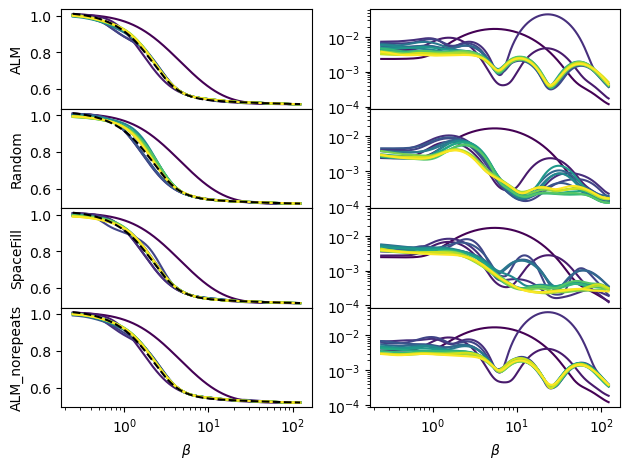

In [8]:
#Plot GP models over update iterations compared to ground truth
fig, ax = plt.subplots(len(update_labels), 2, sharex=True, sharey='col')

run = 'run1'

for i, t_info in enumerate(train_info):
    this_mean = t_info[run]['pred_mu']/bondL2
    this_std = t_info[run]['pred_std']/bondL2
    iter_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_mean.shape[0]))
    for j in range(this_mean.shape[0]):
        ax[i, 0].plot(b_vals, this_mean[j, :], color=iter_colors[j])
        ax[i, 1].plot(b_vals, this_std[j, :], color=iter_colors[j])
    ax[i, 0].plot(b_vals, ground_truth_rg2(log_b_vals), 'k--')
    ax[i, 0].set_ylabel(update_labels[i])

ax[0, 0].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[-1, 0].set_xlabel(r'$\beta$')
ax[-1, 1].set_xlabel(r'$\beta$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

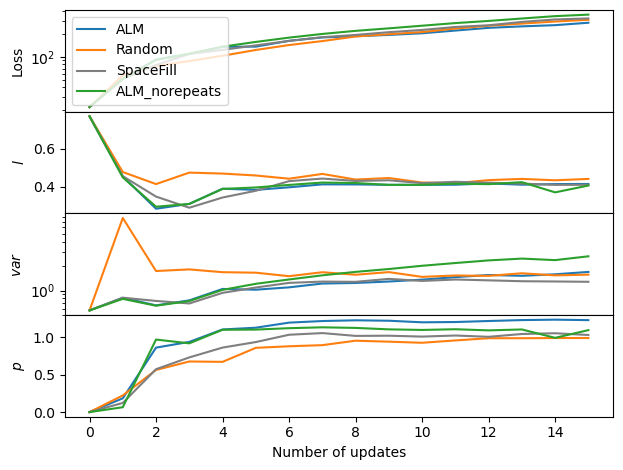

In [9]:
#Look at losses and parameters over update iterations
fig, ax = plt.subplots(4, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_loss = np.array([t_info[r]['loss'] for r in t_info.keys()])
#     ax[0].plot(this_loss.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_loss, axis=0), color=update_colors[i], label=update_labels[i])
    this_params = np.array([t_info[r]['params'] for r in t_info.keys()])
    for j in range(3):
#         ax[j+1].plot(this_params[:, :, j].T, color=update_colors[i], alpha=0.3)
        ax[j+1].plot(np.average(this_params[:, :, j], axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[0].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')
ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

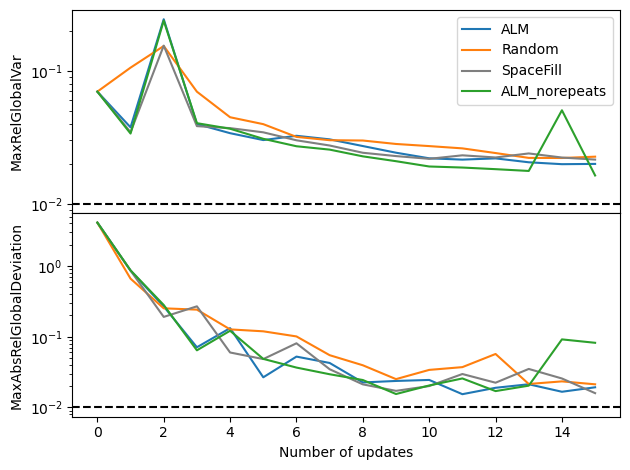

In [10]:
#Metrics for stopping/convergence
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']
metric_names = ['MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

for i, t_info in enumerate(train_info):
    for j, m in enumerate(metric_names):
        this_metric = np.array([t_info[r][m] for r in t_info.keys()])
#         ax[j].plot(this_metric.T, color=update_colors[i], alpha=0.3)
        ax[j].plot(np.average(this_metric, axis=0), color=update_colors[i], label=update_labels[i])

for i, a in enumerate(ax):
    a.set_yscale('log')
    a.axhline(1e-02, color='k', linestyle='--')
    a.set_ylabel(metric_names[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

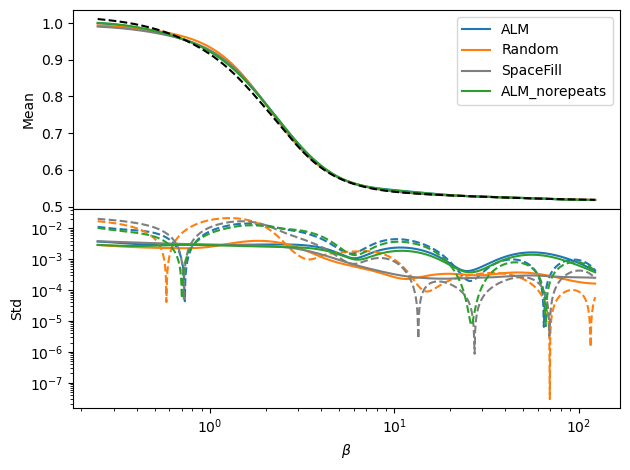

In [11]:
#Nice plot of final results as well
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

run = 'run1'

for i, t_info in enumerate(train_info):
    ax[0].plot(b_vals, t_info[run]['pred_mu'][-1]/bondL2, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, t_info[run]['pred_std'][-1]/bondL2, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(t_info[run]['pred_mu'][-1]/bondL2 - ground_truth_rg2(log_b_vals)),
               color=update_colors[i], linestyle='--')

ax[0].plot(b_vals, ground_truth_rg2(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

In [19]:
#Also interesting to look at the derivative and compare
#For that, though, will need to create GPs and generate predictions
#While we're at it, also generate GP models without derivative information as comparison
gp_models = []
gp_noderivs = []

run = 'run1'

for i, adir in enumerate(update_dirs):
    this_data = load_data('%s/%s/%s'%(base_dir, adir, run), train_info[i][run]['alpha'])
    gp_models.append(active_utils.create_GPR([dat.build_state(max_order=4) for dat in this_data],
                                             log_scale=True,
                                             start_params=train_info[i][run]['params'][-1]))
    
    print(train_info[i][run]['params'][-1])
    print(gp_models[i].trainable_parameters)
    
    #For building models with no derivatives, must work more manually
    x_dat = []
    y_dat = []
    cov_dat = []
    for dat in this_data:
        s = dat.build_state(max_order=1)
        this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s, log_scale=True)
        x_dat.append(this_x_data[::2, ...])
        y_dat.append(this_y_data[::2, ...])
        cov_dat.append(np.diag(this_cov_data[0])[::2]) #Only need diagonal for no derivative info
    
    x_dat = np.vstack(x_dat)
    y_dat = np.vstack(y_dat)
    cov_dat = np.diag(np.hstack(cov_dat))
    
    this_noderiv_gp = active_utils.create_base_GP_model((x_dat, y_dat, cov_dat))
    active_utils.train_GPR(this_noderiv_gp, start_params=train_info[i][run]['params'][-1])
    gp_noderivs.append(this_noderiv_gp)
    
    print(gp_noderivs[i].trainable_parameters)
    

[0.42664692 1.80873947 1.22316074]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.4196895864174043>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.7596854448329136>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.2216442701255144>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.45079014266223477>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.594799920124757>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.7005268289682997e-09>)
[0.36855509 0.84093426 0.86638611]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.33948614128346705>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.7794974017820723>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.8481639251782832>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.

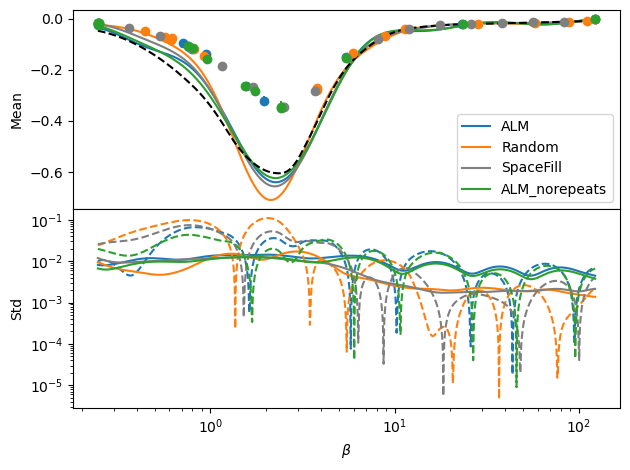

In [20]:
#With GP models, look at first derivative
fig, ax = plt.subplots(2, sharex=True)

d_o = 1

for i, gp in enumerate(gp_models):
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)/bondL2
    this_std = np.squeeze(np.sqrt(this_var))/bondL2
    ax[0].plot(b_vals, this_mu, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, this_std, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(this_mu - ground_truth_rg2.derivative(d_o)(log_b_vals)),
               color=update_colors[i], linestyle='--')
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[0].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
                   gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
                   marker='o', linestyle='', color=update_colors[i])

ax[0].plot(b_vals, ground_truth_rg2.derivative(d_o)(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

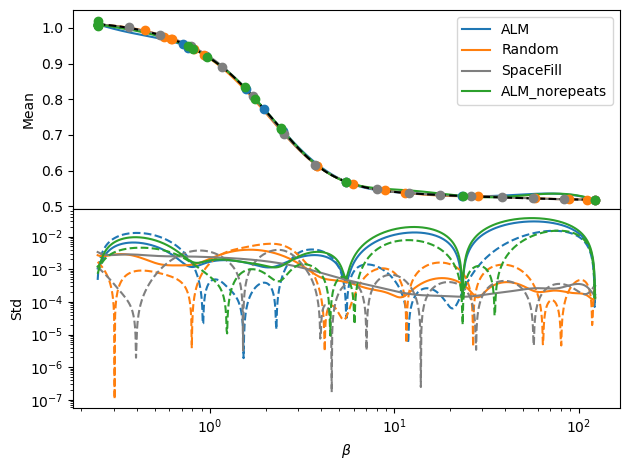

In [21]:
#And compare against GP model without derivative information
fig, ax = plt.subplots(2, sharex=True)

d_o = 0

for i, gp in enumerate(gp_noderivs):
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)/bondL2
    this_std = np.squeeze(np.sqrt(this_var))/bondL2
    ax[0].plot(b_vals, this_mu, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, this_std, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(this_mu - ground_truth_rg2.derivative(d_o)(log_b_vals)),
               color=update_colors[i], linestyle='--')
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[0].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
                   gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
                   marker='o', linestyle='', color=update_colors[i])

ax[0].plot(b_vals, ground_truth_rg2.derivative(d_o)(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

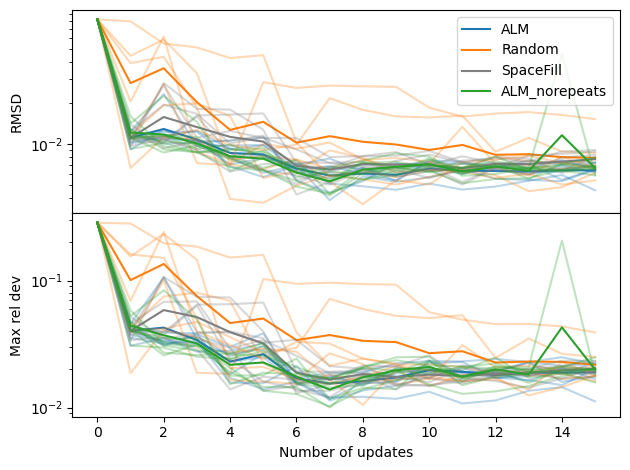

In [22]:
#Look at how far from ground truth
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_means = np.array([t_info[r]['pred_mu'] for r in t_info.keys()])
    this_rmsd = np.sqrt(np.average((this_means/bondL2 - ground_truth_rg2(log_b_vals))**2, axis=-1))    
    this_max_rel_dev = np.max(abs(this_means/bondL2 - ground_truth_rg2(log_b_vals)) / abs(ground_truth_rg2(log_b_vals)), axis=-1)
    ax[0].plot(this_rmsd.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_rmsd, axis=0), color=update_colors[i], label=update_labels[i])
    ax[1].plot(this_max_rel_dev.T, color=update_colors[i], alpha=0.3)
    ax[1].plot(np.average(this_max_rel_dev, axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Nice figures

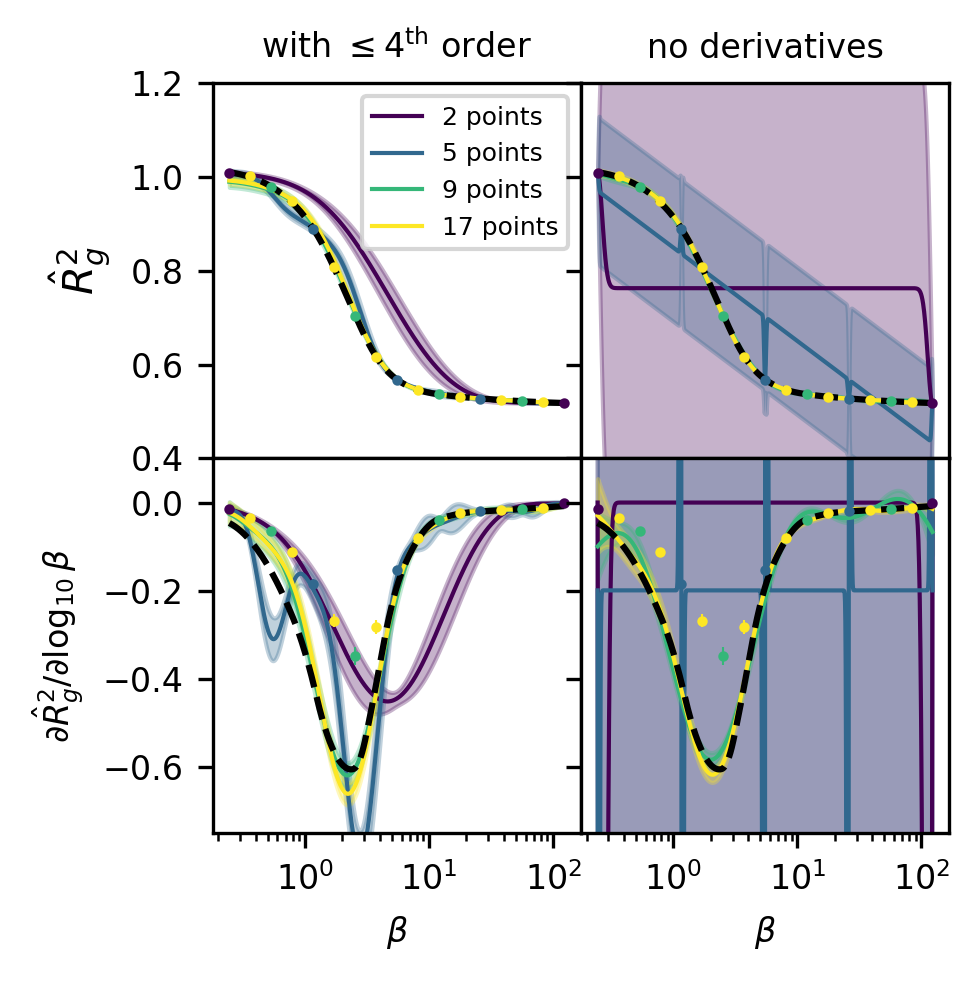

In [30]:
from scipy import linalg

#Showing that derivatives are helpful
#Simultaneously demonstrates bias in first derivative estimates if show that as lower panel
#Only focus on space-filling design with 2, 3, 5, 9, and 17 points
fig, ax = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(3.37, 3.37), dpi=300)

space_iters = [0, 3, 7, 15] #[0, 1, 3, 7, 15]
iter_colors = plt.cm.viridis(np.linspace(0.0, 1.0, len(space_iters)))

run = 'run1'

space_t_info = train_info[2]
space_data = load_data('%s/%s/%s'%(base_dir, update_dirs[2], run), space_t_info[run]['alpha'])
space_states = [dat.build_state(max_order=4) for dat in space_data]

for d_o in [0, 1]:
    
    for i, ind in enumerate(space_iters):
        
        #Prep data
        x_dat = []
        y_dat = []
        cov_dat = []
        for s in space_states[:(ind+2)]:
            this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s, log_scale=True)
            x_dat.append(this_x_data)
            y_dat.append(this_y_data)
            cov_dat.append(this_cov_data)
    
        x_dat_nod = np.vstack([x[::5, ...] for x in x_dat])
        y_dat_nod = np.vstack([y[::5, ...] for y in y_dat])
        cov_dat_nod = np.diag(np.hstack([np.diag(cov[0])[::5] for cov in cov_dat]))
        
        x_dat = np.vstack(x_dat)
        y_dat = np.vstack(y_dat)
        cov_dat = linalg.block_diag(*[cov[0] for cov in cov_dat])
    
        #Create models with and without derivatives
        this_noderiv_gp = active_utils.create_base_GP_model((x_dat_nod, y_dat_nod, cov_dat_nod))
        active_utils.train_GPR(this_noderiv_gp, start_params=space_t_info[run]['params'][ind])
        
        this_gp = active_utils.create_base_GP_model((x_dat, y_dat, cov_dat))
        for j in range(len(this_gp.trainable_parameters)):
            this_gp.trainable_parameters[j].assign(space_t_info[run]['params'][ind][j])
        
        #Make predictions at this derivative order and plot
        for j, gp in enumerate([this_gp, this_noderiv_gp]):
            this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
            this_mu = np.squeeze(this_mu)/bondL2
            this_std = np.squeeze(np.sqrt(this_var))/bondL2
            ax[d_o, j].plot(b_vals, this_mu, color=iter_colors[i], linewidth=1.0, label='%i points'%(ind + 2))
            ax[d_o, j].fill_between(b_vals, this_mu-2.0*this_std, this_mu+2.0*this_std,
                                  color=iter_colors[i], alpha=0.3)
            
            #Plot points used by this iteration (also plotting for derivative prediction with no deriv information)
            max_d = int(np.max(this_gp.data[0][:, 1]))
            if i == 0:
                start_ind = d_o
            else:
                start_ind = (space_iters[i-1] + 2)*(max_d+1) + d_o
            ax[d_o, j].errorbar(10.0**(this_gp.data[0][start_ind::(max_d+1), 0]/gp.x_scale_fac),
                   this_gp.data[1][start_ind::(max_d+1), 0]*(this_gp.x_scale_fac**d_o)*this_gp.scale_fac/bondL2,
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(this_gp.likelihood.cov))[start_ind::(max_d+1)])*(this_gp.x_scale_fac**d_o)*this_gp.scale_fac/bondL2,
                   marker='o', markersize=1.5, linestyle='', elinewidth=0.5, color=iter_colors[i])
    
    for j in range(2):    
        ax[d_o, j].plot(b_vals, ground_truth_rg2.derivative(d_o)(log_b_vals), 'k--')
        ax[d_o, j].tick_params(axis='both', labelsize=8)
    
ax[0, 0].legend(fontsize=6)

ax[0, 0].set_xscale('log')
ax[0, 0].set_ylabel(r'$\hat{R}^2_g$', fontsize=10)
ax[1, 0].set_ylabel(r'$\partial \hat{R}^2_g / \partial \log_{10} \beta$', fontsize=8)
ax[1, 0].set_xlabel(r'$\beta$', fontsize=8)
ax[1, 1].set_xlabel(r'$\beta$', fontsize=8)

ax[0, 0].set_ylim((0.40, 1.2))
ax[1, 0].set_ylim((-0.75, 0.10))

ax[0, 0].set_title(r'with $\leq 4^\mathrm{th}$ order', fontsize=8)
ax[0, 1].set_title(r'no derivatives', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

## Effect of varying $p$ and $s$

In [25]:
#Need to create GP models with various scenarios of p and s constraints
import gpflow

like_kwargs_list = [{'constrain_p': False, 'transform_p': None,
                     'constrain_s': False, 'transform_s': None}, #p and s completely free
                    {'constrain_p': False, 'transform_p': gpflow.utilities.positive(),
                     'constrain_s': False, 'transform_s': None}, #make p positive, s free to change
                    {'constrain_p': False, 'transform_p': gpflow.utilities.positive(),
                     's': 1.0, 'constrain_s': False, 'transform_s': gpflow.utilities.positive()}, #p and s both positive
                    {'constrain_p': False, 'transform_p': None,
                     's': 1.0, 'constrain_s': False, 'transform_s': gpflow.utilities.positive()}, #p free, s positive
                    {'constrain_p': False, 'transform_p': None,
                     'constrain_s': True, 'transform_s': None}, #s constrained, p fully free
                    {'constrain_p': False, 'transform_p': gpflow.utilities.positive(),
                     'constrain_s': True, 'transform_s': None}, #s constrained, p positive
                    {'p': 0.0, 'constrain_p': True, 'transform_p': None,
                     'constrain_s': False, 'transform_s': None}, #p constrained, s fully free
                    {'p': 0.0, 'constrain_p': True, 'transform_p': None,
                     's': 1.0, 'constrain_s': False, 'transform_s': gpflow.utilities.positive()}, #p constrained, s positive
                    {'p': 0.0, 'constrain_p': True, 'transform_p': None,
                     'constrain_s': True, 'transform_s': None}, #both constrained
                   ]

ps_labels = ['p free, s free', 'p pos, s free', 'p pos, s pos', 'p free, s pos',
             'p free, s con', 'p pos, s con', 'p con, s free', 'p con, s pos', 'p con, s con']

ps_gp_models = []
run = 'run1'
space_data = load_data('%s/%s/%s'%(base_dir, update_dirs[2], run), train_info[2][run]['alpha'][:9])
space_states = [dat.build_state(max_order=4) for dat in space_data]
for i, kw in enumerate(like_kwargs_list):
    alt_start_par = [1.0, 1.0, 0.0, -10.0] #l, var, s, p
    if kw['transform_p'] is not None:
        alt_start_par[3] = 0.01
    if kw['transform_s'] is not None:
        alt_start_par[2] = 1.0
    if kw['constrain_p']:
        alt_start_par[3] = 0.0
    if kw['constrain_s']:
        alt_start_par.pop(2) #If s is constrained, remove it from list (p is at end, so won't matter)
    print(alt_start_par)
    ps_gp_models.append(active_utils.create_GPR(space_states,
                                                log_scale=True,
                                                start_params=alt_start_par,
                                                base_kwargs={'likelihood_kwargs': kw}))
    gpflow.utilities.print_summary(ps_gp_models[-1])
    

[1.0, 1.0, 0.0, -10.0]
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │     value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  3.56212  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │  0.715538 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼───────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Identity    │         │

╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.9837   │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.579162 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.likelihood.power_scale │ Parameter │ Identity    │         │ False       │ ()      │ float

tf.Tensor(116.14083816259713, shape=(), dtype=float64)
tf.Tensor(132.34262710774584, shape=(), dtype=float64)
tf.Tensor(132.5426488029679, shape=(), dtype=float64)
tf.Tensor(259.9921805413943, shape=(), dtype=float64)
tf.Tensor(180.4058037126337, shape=(), dtype=float64)
tf.Tensor(180.28554759808497, shape=(), dtype=float64)
tf.Tensor(134.13561415957633, shape=(), dtype=float64)
tf.Tensor(131.45663916704618, shape=(), dtype=float64)
tf.Tensor(259.6754886609059, shape=(), dtype=float64)


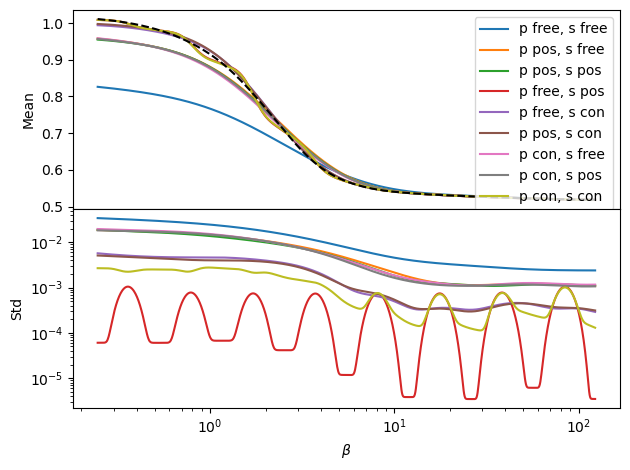

In [26]:
#Plot models with different p and s
fig, ax = plt.subplots(2, sharex=True)

d_o = 0

for i, gp in enumerate(ps_gp_models):
    print(gp.training_loss())
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)/bondL2
    this_std = np.squeeze(np.sqrt(this_var))/bondL2
    ax[0].plot(b_vals, this_mu, label=ps_labels[i])
    ax[1].plot(b_vals, this_std, label=ps_labels[i])
    
ax[0].plot(b_vals, ground_truth_rg2.derivative(d_o)(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

### Nice figures

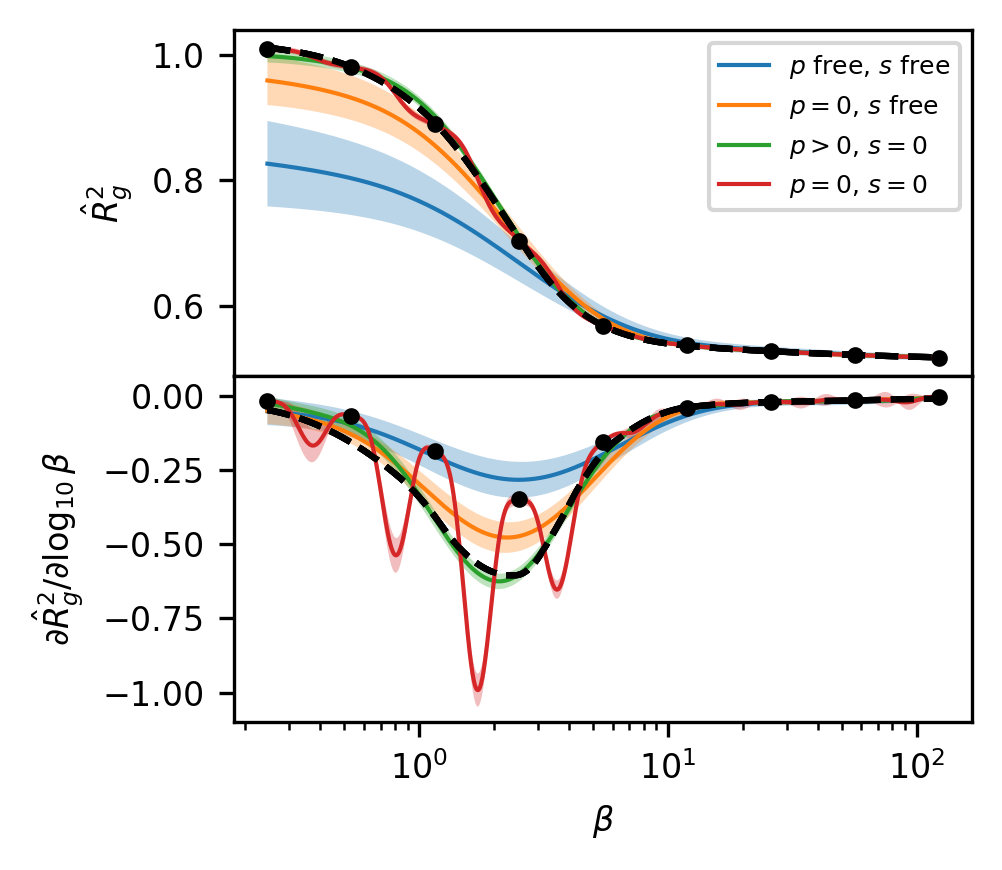

In [33]:
#Plot models with different p and s
fig, ax = plt.subplots(2, sharex=True, figsize=(3.37, 3.0), dpi=300)

nice_ps_labels = [r'$p$ free, $s$ free', r'$p = 0$, $s$ free', r'$p > 0$, $s = 0$', r'$p = 0$, $s = 0$']

for d_o in [0, 1]:
    for i, ind in enumerate([0, 6, 5, -1]):
        gp = ps_gp_models[ind]
        this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
        this_mu = np.squeeze(this_mu)/bondL2
        this_std = np.squeeze(np.sqrt(this_var))/bondL2
        ax[d_o].plot(b_vals, this_mu, linewidth=1.0, label=nice_ps_labels[i])
        ax[d_o].fill_between(b_vals, this_mu-2.0*this_std, this_mu+2.0*this_std, alpha=0.3)
        ax[d_o].plot(b_vals, ground_truth_rg2.derivative(d_o)(log_b_vals), 'k--')
    gp = ps_gp_models[0]
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[d_o].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
              gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
              yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac/bondL2,
              marker='o', linestyle='', color='k', markersize=3.0, elinewidth=0.5)
    ax[d_o].tick_params(axis='both', labelsize=8)

ax[0].legend(fontsize=6)

ax[0].set_xscale('log')

ax[-1].set_xlabel(r'$\beta$', fontsize=8)
ax[0].set_ylabel(r'$\hat{R}^2_g$', fontsize=8)
ax[1].set_ylabel(r'$\partial \hat{R}^2_g / \partial \log_{10}\beta$', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

# $U$

In [7]:
#Load all training information
update_labels = ['ALM', 'Random', 'SpaceFill']
update_dirs = ['U_log_%s'%lab for lab in update_labels]
train_info = []
for u_dir in update_dirs:
    this_t_info = {}
    for i in range(3):
        this_t_info['run%i'%(i+1)] = np.load('%s/%s/run%i/active_history.npz'%(base_dir, u_dir, i+1))
    train_info.append(this_t_info)

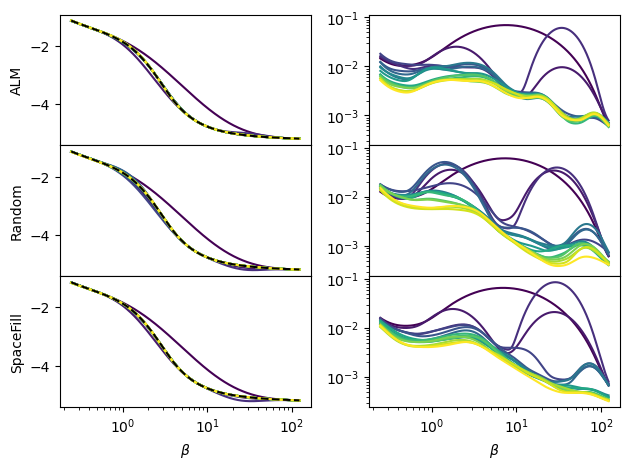

In [8]:
#Plot GP models over update iterations compared to ground truth
fig, ax = plt.subplots(len(update_labels), 2, sharex=True, sharey='col')

run = 'run1'

for i, t_info in enumerate(train_info):
    this_mean = t_info[run]['pred_mu']/eps
    this_std = t_info[run]['pred_std']/eps
    iter_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_mean.shape[0]))
    for j in range(this_mean.shape[0]):
        ax[i, 0].plot(b_vals, this_mean[j, :], color=iter_colors[j])
        ax[i, 1].plot(b_vals, this_std[j, :], color=iter_colors[j])
    ax[i, 0].plot(b_vals, ground_truth_u(log_b_vals), 'k--')
    ax[i, 0].set_ylabel(update_labels[i])

ax[0, 0].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[-1, 0].set_xlabel(r'$\beta$')
ax[-1, 1].set_xlabel(r'$\beta$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

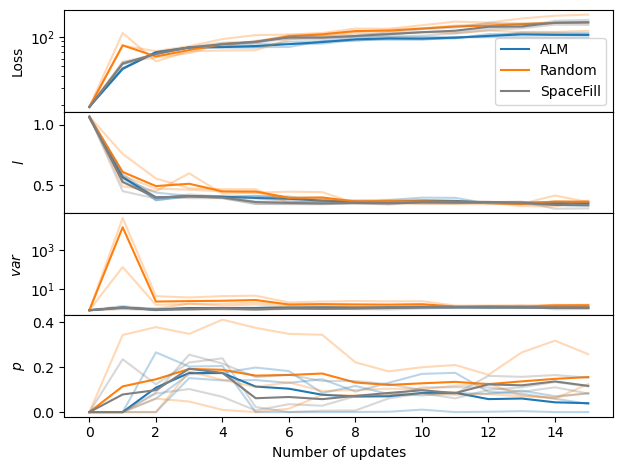

In [9]:
#Look at losses and paramters over update iterations
fig, ax = plt.subplots(4, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_loss = np.array([t_info[r]['loss'] for r in t_info.keys()])
    ax[0].plot(this_loss.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_loss, axis=0), color=update_colors[i], label=update_labels[i])
    this_params = np.array([t_info[r]['params'] for r in t_info.keys()])
    for j in range(3):
        ax[j+1].plot(this_params[:, :, j].T, color=update_colors[i], alpha=0.3)
        ax[j+1].plot(np.average(this_params[:, :, j], axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[0].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')
ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

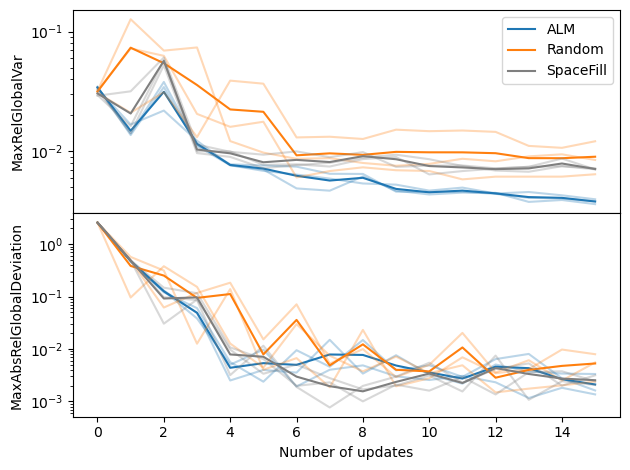

In [11]:
#Metrics for stopping/convergence
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']
metric_names = ['MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

for i, t_info in enumerate(train_info):
    for j, m in enumerate(metric_names):
        this_metric = np.array([t_info[r][m] for r in t_info.keys()])
        ax[j].plot(this_metric.T, color=update_colors[i], alpha=0.3)
        ax[j].plot(np.average(this_metric, axis=0), color=update_colors[i], label=update_labels[i])

for i, a in enumerate(ax):
    a.set_yscale('log')
    #a.axhline(1e-02, color='k', linestyle='--')
    a.set_ylabel(metric_names[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

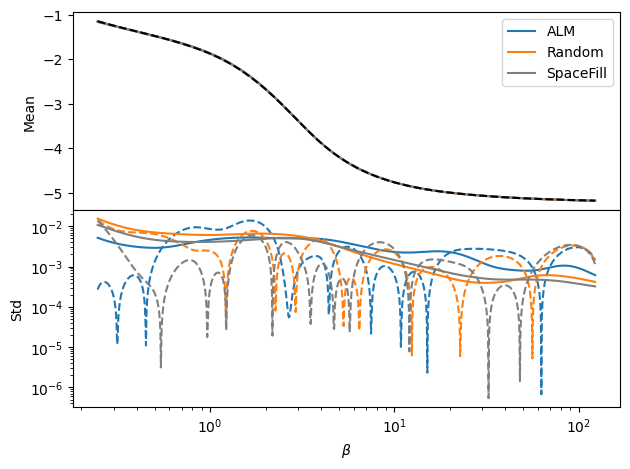

In [12]:
#Nice plot of final results as well
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

run = 'run1'

for i, t_info in enumerate(train_info):
    ax[0].plot(b_vals, t_info[run]['pred_mu'][-1]/eps, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, t_info[run]['pred_std'][-1]/eps, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(t_info[run]['pred_mu'][-1]/eps - ground_truth_u(log_b_vals)),
               color=update_colors[i], linestyle='--')

ax[0].plot(b_vals, ground_truth_u(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

In [13]:
#Also interesting to look at the derivative and compare
#For that, though, will need to create GPs and generate predictions
#While we're at it, also generate GP models without derivative information as comparison
gp_models = []
gp_noderivs = []

run = 'run1'

for i, adir in enumerate(update_dirs):
    this_data = load_data('%s/%s/%s'%(base_dir, adir, run), train_info[i][run]['alpha'])
    gp_models.append(active_utils.create_GPR([dat.build_state(max_order=4) for dat in this_data],
                                             log_scale=True,
                                             start_params=train_info[i][run]['params'][-1]))
    
    print(train_info[i][run]['params'][-1])
    print(gp_models[i].trainable_parameters)
    
    #For building models with no derivatives, must work more manually
    x_dat = []
    y_dat = []
    cov_dat = []
    for dat in this_data:
        s = dat.build_state(max_order=1)
        this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s, log_scale=True)
        x_dat.append(this_x_data[::2, ...])
        y_dat.append(this_y_data[::2, ...])
        cov_dat.append(np.diag(this_cov_data)[::2]) #Only need diagonal for no derivative info
    
    x_dat = np.vstack(x_dat)
    y_dat = np.vstack(y_dat)
    cov_dat = np.diag(np.hstack(cov_dat))
    
    this_noderiv_gp = active_utils.create_base_GP_model((x_dat, y_dat, cov_dat))
    active_utils.train_GPR(this_noderiv_gp, start_params=train_info[i][run]['params'][-1])
    gp_noderivs.append(this_noderiv_gp)
    
    print(gp_noderivs[i].trainable_parameters)
    

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2022-09-29 08:53:46.228689: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[0.35465846 1.13554133 0.08265228]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.354545709721988>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.1465926249420049>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.07410006506615094>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.3988429822583889>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.3233501543123536>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.17775562163168274>)
[0.37222912 1.37299426 0.12478189]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.3763725320488185>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.4254581652780451>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.13321929557460188>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.471

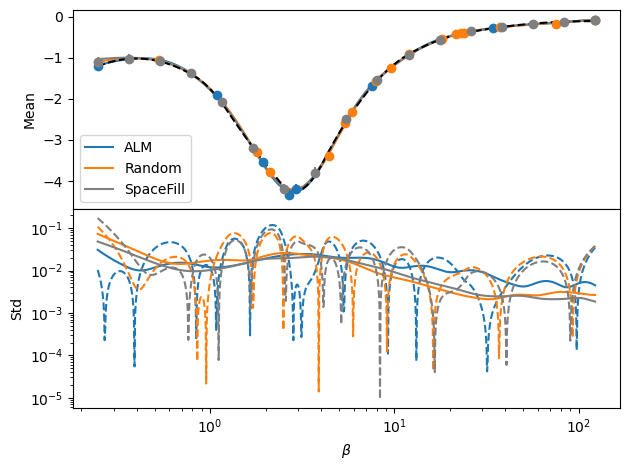

In [14]:
#With GP models, look at first derivative
fig, ax = plt.subplots(2, sharex=True)

d_o = 1

for i, gp in enumerate(gp_models):
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)/eps
    this_std = np.squeeze(np.sqrt(this_var))/eps
    ax[0].plot(b_vals, this_mu, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, this_std, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(this_mu - ground_truth_u.derivative(d_o)(log_b_vals)),
               color=update_colors[i], linestyle='--')
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[0].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
                   gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac/eps,
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac/eps,
                   marker='o', linestyle='', color=update_colors[i])

ax[0].plot(b_vals, ground_truth_u.derivative(d_o)(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

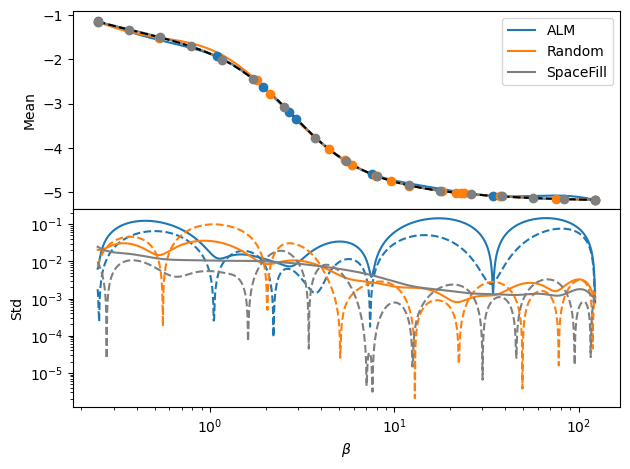

In [15]:
#And compare against GP model without derivative information
fig, ax = plt.subplots(2, sharex=True)

d_o = 0

for i, gp in enumerate(gp_noderivs):
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)/eps
    this_std = np.squeeze(np.sqrt(this_var))/eps
    ax[0].plot(b_vals, this_mu, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, this_std, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(this_mu - ground_truth_u.derivative(d_o)(log_b_vals)),
               color=update_colors[i], linestyle='--')
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[0].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
                   gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac/eps,
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac/eps,
                   marker='o', linestyle='', color=update_colors[i])

ax[0].plot(b_vals, ground_truth_u.derivative(d_o)(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

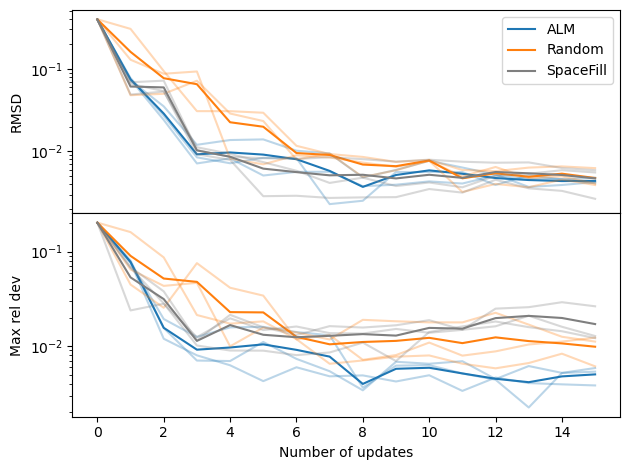

In [16]:
#Look at how far from ground truth
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_means = np.array([t_info[r]['pred_mu'] for r in t_info.keys()]) / eps
    this_rmsd = np.sqrt(np.average((this_means - ground_truth_u(log_b_vals))**2, axis=-1))    
    this_max_rel_dev = np.max(abs(this_means - ground_truth_u(log_b_vals)) / abs(ground_truth_u(log_b_vals)), axis=-1)
    ax[0].plot(this_rmsd.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_rmsd, axis=0), color=update_colors[i], label=update_labels[i])
    ax[1].plot(this_max_rel_dev.T, color=update_colors[i], alpha=0.3)
    ax[1].plot(np.average(this_max_rel_dev, axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

# $C_V$

In [34]:
#Load all training information
update_labels = ['ALM', 'Random', 'SpaceFill', 'ALM_norepeats']
update_dirs = ['Cv_log_%s'%lab for lab in update_labels]
train_info = []
for u_dir in update_dirs:
    this_t_info = {}
    for i in range(8):
        this_t_info['run%i'%(i+1)] = np.load('%s/%s/run%i/active_history.npz'%(base_dir, u_dir, i+1))
    train_info.append(this_t_info)

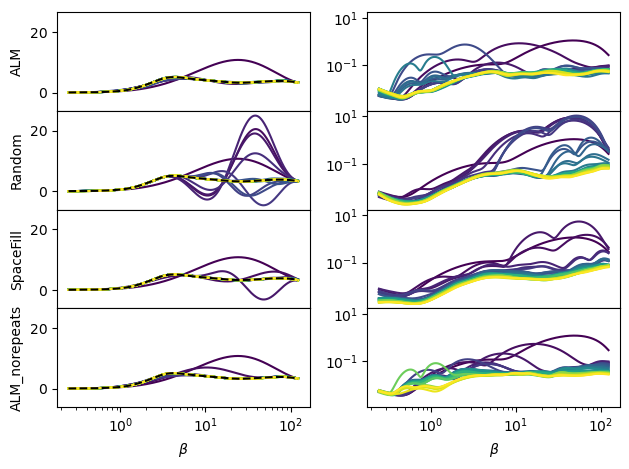

In [35]:
#Plot GP models over update iterations compared to ground truth
fig, ax = plt.subplots(len(update_labels), 2, sharex=True, sharey='col')

run = 'run1'

for i, t_info in enumerate(train_info):
    this_mean = t_info[run]['pred_mu']*(-1)
    this_std = t_info[run]['pred_std']
    iter_colors = plt.cm.viridis(np.linspace(0.0, 1.0, this_mean.shape[0]))
    for j in range(this_mean.shape[0]):
        ax[i, 0].plot(b_vals, this_mean[j, :], color=iter_colors[j])
        ax[i, 1].plot(b_vals, this_std[j, :], color=iter_colors[j])
    ax[i, 0].plot(b_vals, ground_truth_cv(log_b_vals), 'k--')
    ax[i, 0].set_ylabel(update_labels[i])

ax[0, 0].set_xscale('log')
ax[0, 1].set_yscale('log')
ax[-1, 0].set_xlabel(r'$\beta$')
ax[-1, 1].set_xlabel(r'$\beta$')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

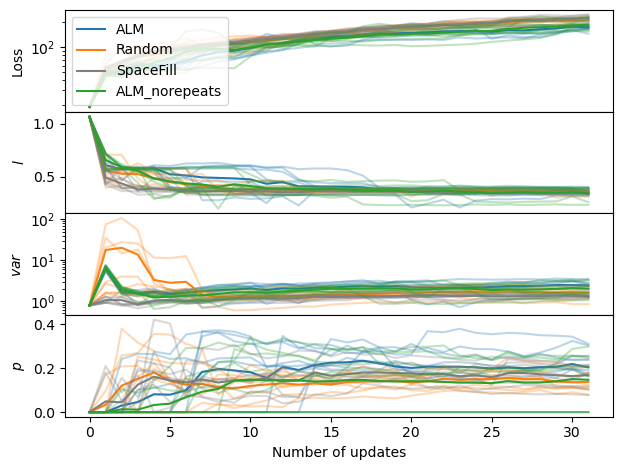

In [36]:
#Look at losses and parameters over update iterations
fig, ax = plt.subplots(4, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_loss = np.array([t_info[r]['loss'] for r in t_info.keys()])
    ax[0].plot(this_loss.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_loss, axis=0), color=update_colors[i], label=update_labels[i])
    this_params = np.array([t_info[r]['params'] for r in t_info.keys()])
    for j in range(3):
        ax[j+1].plot(this_params[:, :, j].T, color=update_colors[i], alpha=0.3)
        ax[j+1].plot(np.average(this_params[:, :, j], axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[0].set_yscale('log')
ax[2].set_yscale('log')

ax[0].set_ylabel('Loss')
ax[1].set_ylabel(r'$l$')
ax[2].set_ylabel(r'$var$')
ax[3].set_ylabel(r'$p$')
ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

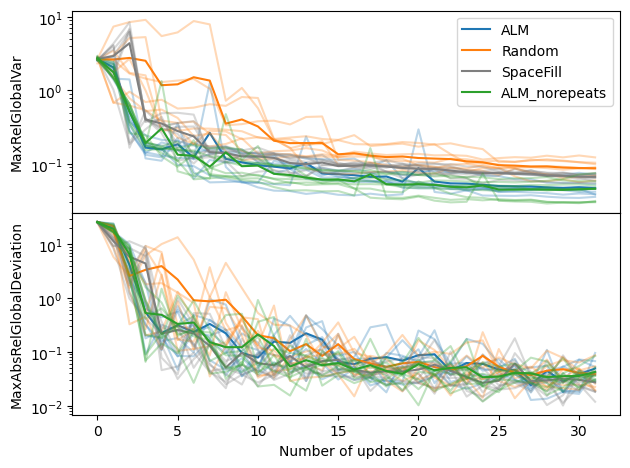

In [37]:
#Metrics for stopping/convergence
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']
metric_names = ['MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

for i, t_info in enumerate(train_info):
    for j, m in enumerate(metric_names):
        this_metric = np.array([t_info[r][m] for r in t_info.keys()])
        ax[j].plot(this_metric.T, color=update_colors[i], alpha=0.3)
        ax[j].plot(np.average(this_metric, axis=0), color=update_colors[i], label=update_labels[i])

for i, a in enumerate(ax):
    a.set_yscale('log')
    #a.axhline(1e-02, color='k', linestyle='--')
    a.set_ylabel(metric_names[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

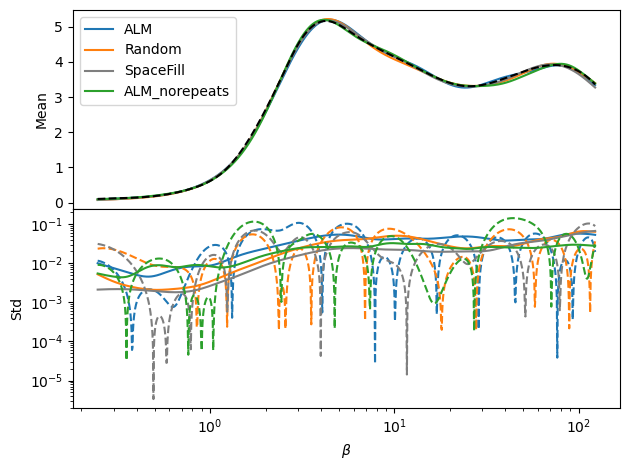

In [38]:
#Nice plot of final results as well
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

run = 'run1'

for i, t_info in enumerate(train_info):
    ax[0].plot(b_vals, t_info[run]['pred_mu'][-1]*(-1), color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, t_info[run]['pred_std'][-1], color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(t_info[run]['pred_mu'][-1]*(-1) - ground_truth_cv(log_b_vals)),
               color=update_colors[i], linestyle='--')

ax[0].plot(b_vals, ground_truth_cv(log_b_vals), 'k--')

ax[0].legend()

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean')
ax[1].set_ylabel('Std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

In [40]:
#Also interesting to look at the derivative and compare
#For that, though, will need to create GPs and generate predictions
#While we're at it, also generate GP models without derivative information as comparison
gp_models = []
gp_noderivs = []

run = 'run1'

for i, adir in enumerate(update_dirs):
    this_data = load_data('%s/%s/%s'%(base_dir, adir, run), train_info[i][run]['alpha'])
    gp_models.append(active_utils.create_GPR([dat.build_state(max_order=4) for dat in this_data],
                                             log_scale=True,
                                             start_params=train_info[i][run]['params'][-1]))
    
    print(train_info[i][run]['params'][-1])
    print(gp_models[i].trainable_parameters)
    
    #For building models with no derivatives, must work more manually
    x_dat = []
    y_dat = []
    cov_dat = []
    for dat in this_data:
        s = dat.build_state(max_order=1)
        this_x_data, this_y_data, this_cov_data = active_utils.input_GP_from_state(s, log_scale=True)
        x_dat.append(this_x_data[::2, ...])
        y_dat.append(this_y_data[::2, ...])
        cov_dat.append(np.diag(this_cov_data[0])[::2]) #Only need diagonal for no derivative info
    
    x_dat = np.vstack(x_dat)
    y_dat = np.vstack(y_dat)
    cov_dat = np.diag(np.hstack(cov_dat))
    
    this_noderiv_gp = active_utils.create_base_GP_model((x_dat, y_dat, cov_dat))
    active_utils.train_GPR(this_noderiv_gp, start_params=train_info[i][run]['params'][-1])
    gp_noderivs.append(this_noderiv_gp)
    
    print(gp_noderivs[i].trainable_parameters)
    

[0.38679095 1.78321879 0.30391324]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.38733616446898683>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.7189441870607063>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.30428673851138693>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.4638788213811823>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=2.1358990686789605>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.3558873654592397>)
[0.37837007 1.70249035 0.2124526 ]
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.3788685159237695>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=1.7536898771308869>, <Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.19838126820183263>)
(<Parameter: name=softplus, dtype=float64, shape=[], fn="softplus", numpy=0.45

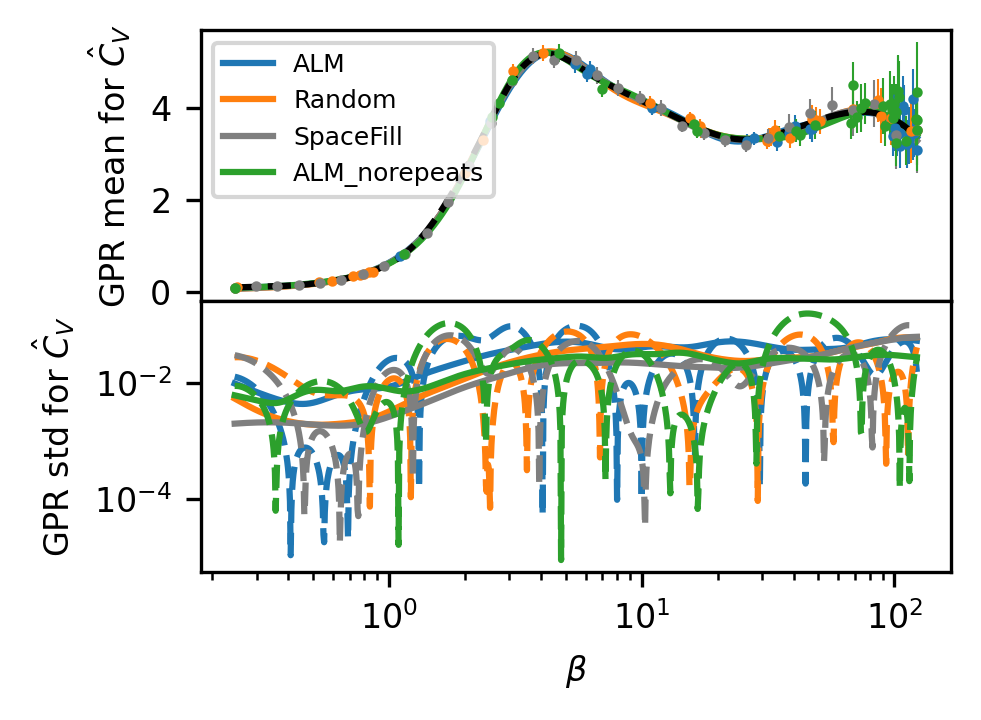

In [43]:
#Look at Cv from GP models (1st derivative of GP)
fig, ax = plt.subplots(2, sharex=True, figsize=(3.37, 2.5), dpi=300)

d_o = 1

for i, gp in enumerate(gp_models):
    this_mu, this_var = gp.predict_f(np.vstack([log_b_vals, d_o*np.ones_like(log_b_vals)]).T)
    this_mu = np.squeeze(this_mu)*(-1)*(b_vals/np.log(10.0))
    this_std = np.squeeze(np.sqrt(this_var))*(b_vals/np.log(10.0))
    ax[0].plot(b_vals, this_mu, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, this_std, color=update_colors[i], label=update_labels[i])
    ax[1].plot(b_vals, abs(this_mu - ground_truth_cv.derivative(d_o - 1)(log_b_vals)),
               color=update_colors[i], linestyle='--')
    max_d = int(np.max(gp.data[0][:, 1]))
    ax[0].errorbar(10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac),
                   gp.data[1][d_o::(max_d+1), 0]*(gp.x_scale_fac**d_o)*gp.scale_fac*(-1)*((10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac))/np.log(10.0)),
                   yerr=2.0*np.sqrt(np.diag(np.squeeze(gp.likelihood.cov))[d_o::(max_d+1)])*(gp.x_scale_fac**d_o)*gp.scale_fac*((10.0**(gp.data[0][d_o::(max_d+1), 0]/gp.x_scale_fac))/np.log(10.0)),
                   marker='o', linestyle='', markersize=1.5, elinewidth=0.5, color=update_colors[i])

for a in ax:
    a.tick_params(axis='both', labelsize=8)

ax[0].plot(b_vals, ground_truth_cv.derivative(d_o - 1)(log_b_vals), 'k--')

ax[0].legend(fontsize=6)

ax[0].set_xscale('log')
ax[1].set_yscale('log')

ax[-1].set_xlabel(r'$\beta$', fontsize=8)
ax[0].set_ylabel(r'GPR mean for $\hat{C}_V$', fontsize=8)
ax[1].set_ylabel(r'GPR std for $\hat{C}_V$', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

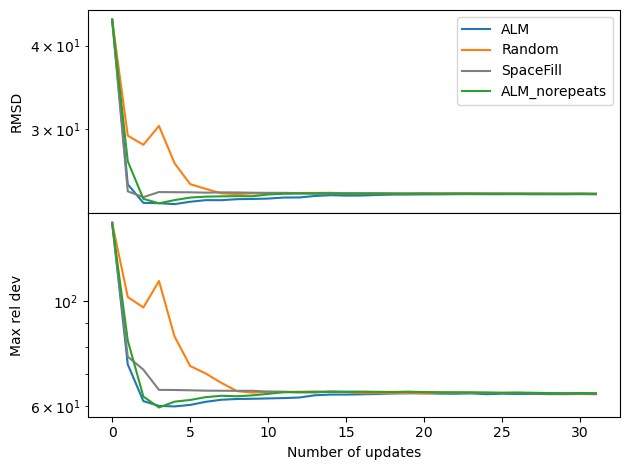

In [24]:
#Look at how far from ground truth
fig, ax = plt.subplots(2, sharex=True)

update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

for i, t_info in enumerate(train_info):
    this_means = np.array([t_info[r]['pred_mu'] for r in t_info.keys()])
    this_rmsd = np.sqrt(np.average((this_means/bondL2 - ground_truth_rg2(log_b_vals))**2, axis=-1))    
    this_max_rel_dev = np.max(abs(this_means/bondL2 - ground_truth_rg2(log_b_vals)) / abs(ground_truth_rg2(log_b_vals)), axis=-1)
#     ax[0].plot(this_rmsd.T, color=update_colors[i], alpha=0.3)
    ax[0].plot(np.average(this_rmsd, axis=0), color=update_colors[i], label=update_labels[i])
#     ax[1].plot(this_max_rel_dev.T, color=update_colors[i], alpha=0.3)
    ax[1].plot(np.average(this_max_rel_dev, axis=0), color=update_colors[i], label=update_labels[i])

ax[0].legend()

ax[-1].set_xlabel('Number of updates')
ax[0].set_ylabel('RMSD')
ax[1].set_ylabel(r'Max rel dev')

ax[0].set_yscale('log')
ax[1].set_yscale('log')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

# Nice summary figures

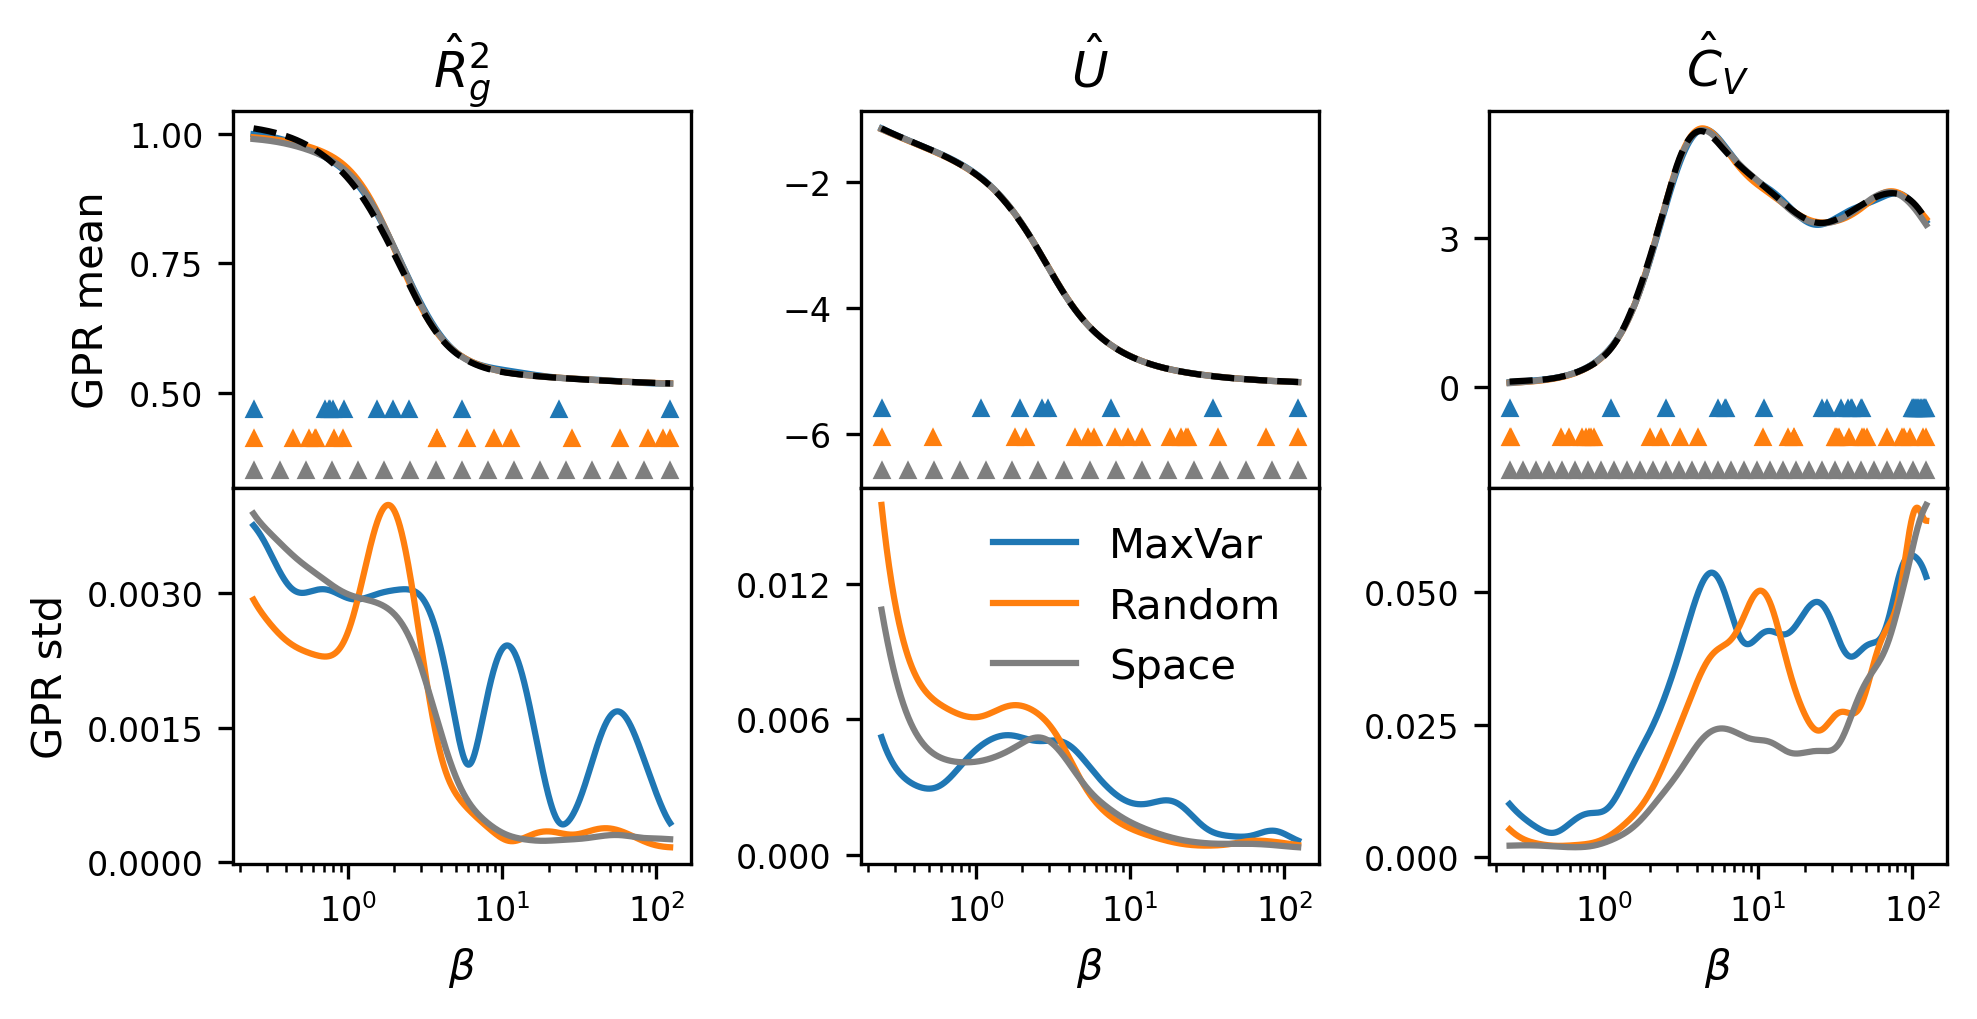

In [48]:
#For Rg, U, and Cv, plot deviations from ground truth in upper panel and uncertainties in lower
#On each plot, present all update strategies to illustrate differences in how they work
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(6.69, 3.5), dpi=300)

update_names = ['ALM', 'Random', 'SpaceFill']
update_labels = ['MaxVar', 'Random', 'Space']
update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']
update_markers = ['^', '^', '^']

run = 'run1'

obs_names = ['Rg', 'U', 'Cv']
obs_labels = [r'$\hat{R}^2_g$', r'$\hat{U}$', r'$\hat{C}_V$']

for i, obs in enumerate(obs_names):
    
    if obs == 'Rg':
        norm_fac = bondL2
        gt_func = ground_truth_rg2
    elif obs == 'U':
        norm_fac = eps
        gt_func = ground_truth_u
    elif obs == 'Cv':
        norm_fac = (-1)
        gt_func = ground_truth_cv
    
    for j, lab in enumerate(update_names):

        #Load training information
        t_info = np.load('%s/%s_log_%s/%s/active_history.npz'%(base_dir, obs, lab, run))
        
        #Plot deviations from ground truth
        ax[0, i].plot(b_vals, t_info['pred_mu'][-1, :]/norm_fac,
                      color=update_colors[j], label=update_labels[j])
#         ax[1, i].plot(b_vals, abs(t_info['pred_mu'][-1, :]/norm_fac - gt_func(log_b_vals)),
#                       color=update_colors[j], label=update_labels[j])
        ax[1, i].plot(b_vals, abs(t_info['pred_std'][-1, :]/norm_fac),
                      color=update_colors[j], label=update_labels[j])
        
        #Plot points for where values selected for this update scheme
        y_lims = ax[0, i].get_ylim()
        y_range = y_lims[1] - y_lims[0]
        ax[0, i].plot(t_info['alpha'], (y_lims[0] - 0.05*y_range)*np.ones_like(t_info['alpha']),
                      linestyle='', color=update_colors[j], marker=update_markers[j], markersize=3)
        
    ax[0, i].plot(b_vals, gt_func(log_b_vals), 'k--')
        
ax[1, 1].legend(frameon=False)

ax[1, 0].set_xscale('log')
for i in range(3):
    ax[0, i].set_title(obs_labels[i])
    ax[-1, i].set_xlabel(r'$\beta$')
    #ax[1, i].set_yscale('log')
    #ax[1, i].set_ylim((10e-06, 10e-02))
    #ax[2, i].set_yscale('log')
    #ax[2, i].set_ylim((10e-06, 10e-02))
    for j in range(2):
        ax[j, i].yaxis.set_major_locator(MaxNLocator(prune='both', nbins=3))
        ax[j, i].tick_params(axis='both', labelsize=8)

ax[0, 0].set_ylabel(r'GPR mean')
# ax[1, 0].set_ylabel(r'Abs deviation')
ax[1, 0].set_ylabel(r'GPR std')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

[122.7268929   61.36344645  24.54537858  12.27268929   6.13634465   4.09089643   3.06817232   2.45453786   1.22726893   0.81817929   0.61363446   0.24545379] [122.7268929   61.52536279  24.50229561  12.28347423   6.11975437   4.0843724    3.06795112   2.45238276   1.22942687   0.8205292    0.61251323   0.24545379]


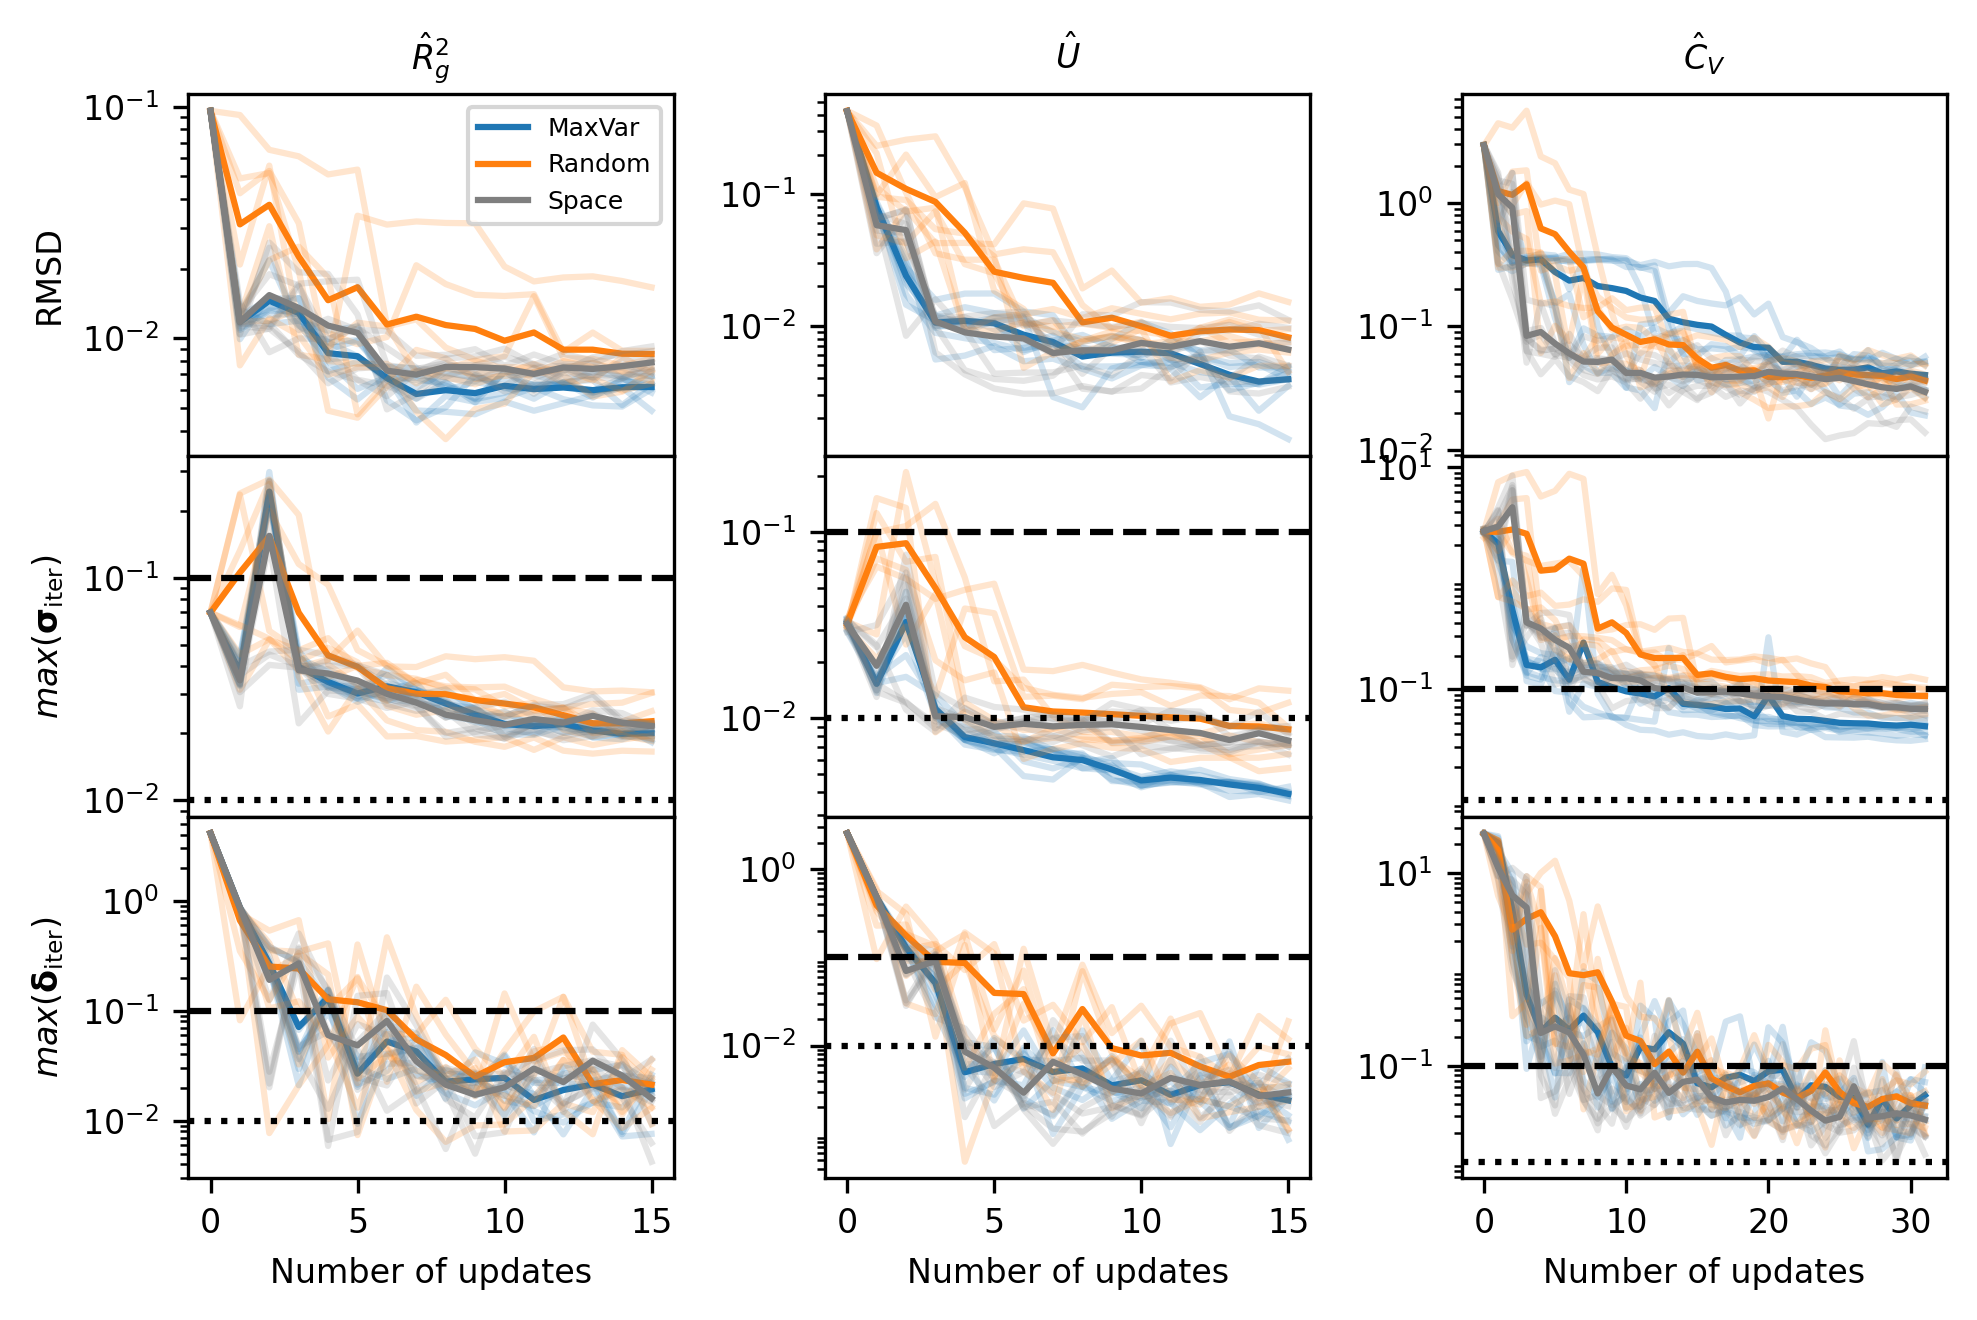

In [60]:
#And another figure with three columns of Rg, U, and Cv
#But now just plot RMSD from ground truth
fig, ax = plt.subplots(3, 3, sharex='col', sharey=False, figsize=(6.69, 4.5), dpi=300)

update_names = ['ALM', 'Random', 'SpaceFill']
update_labels = ['MaxVar', 'Random', 'Space']
update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

obs_names = ['Rg', 'U', 'Cv']
obs_labels = [r'$\hat{R}^2_g$', r'$\hat{U}$', r'$\hat{C}_V$']

num_runs = 8

#May only want to compare RMSD at specific points...
#Dashed curves are spline fits to smallish number of data points, so may not be good reference
#Select points closest to data points
compare_rmsd_inds = [np.argmin(abs(b_vals - b)) for b in b_analytic]
print(b_analytic, b_vals[compare_rmsd_inds])

for i, obs in enumerate(obs_names):
    
    if obs == 'Rg':
        norm_fac = bondL2
        gt_func = ground_truth_rg2
        gt_vals = rg2_red_analytic
    elif obs == 'U':
        norm_fac = eps
        gt_func = ground_truth_u
        gt_vals = u_red_analytic
    elif obs == 'Cv':
        norm_fac = (-1)
        gt_func = ground_truth_cv
        gt_vals = cv_red_analytic
    
    for j, lab in enumerate(update_names):
        
        this_rmsd = []
        this_uncert = []
        this_dev = []
        for r in range(1, num_runs+1):
            #Load training information
            t_info = np.load('%s/%s_log_%s/run%i/active_history.npz'%(base_dir, obs, lab, r))
            this_rmsd.append(np.sqrt(np.average((t_info['pred_mu'][:, compare_rmsd_inds]/norm_fac - gt_vals)**2, axis=-1)))
            # this_rmsd.append(np.sqrt(np.average((t_info['pred_mu']/norm_fac - gt_func(log_b_vals))**2, axis=-1)))
            try:
                this_uncert.append(t_info['MaxRelGlobalVar'])
                this_dev.append(t_info['MaxAbsRelGlobalDeviation'])
            except KeyError:
                this_uncert.append(t_info['MaxRelVar'])
                this_dev.append(t_info['MaxAbsRelDev'])
        
        this_rmsd = np.array(this_rmsd)
        this_uncert = np.array(this_uncert)
        this_dev = np.array(this_dev)
        
        ax[0, i].plot(np.average(this_rmsd, axis=0), color=update_colors[j], label=update_labels[j])
        ax[0, i].plot(this_rmsd.T, color=update_colors[j], alpha=0.2)
        ax[1, i].plot(np.average(this_uncert, axis=0), color=update_colors[j], label=update_labels[j])
        ax[1, i].plot(this_uncert.T, color=update_colors[j], alpha=0.2)
        ax[2, i].plot(np.average(this_dev, axis=0), color=update_colors[j], label=update_labels[j])
        ax[2, i].plot(this_dev.T, color=update_colors[j], alpha=0.2)        
        
ax[0, 0].legend(fontsize=6)

for i in range(3):
    ax[-1, i].set_xlabel(r'Number of updates', fontsize=8)
    ax[0, i].set_title(obs_labels[i], fontsize=8)
    ax[1, i].axhline(1e-01, color='k', linestyle='--')
    ax[1, i].axhline(1e-02, color='k', linestyle=':')
    ax[2, i].axhline(1e-01, color='k', linestyle='--')
    ax[2, i].axhline(1e-02, color='k', linestyle=':')
    for j in range(3):
        ax[i, j].set_yscale('log')
        ax[i, j].yaxis.set_major_locator(LogLocator(numticks=3))
        ax[i, j].tick_params(axis='both', labelsize=8)

ax[0, 0].set_ylabel(r'RMSD', fontsize=8)
ax[1, 0].set_ylabel(r'$max \left( \mathbf{\sigma}_\mathrm{iter} \right)$', fontsize=8)
ax[2, 0].set_ylabel(r'$max \left( \mathbf{\delta}_\mathrm{iter} \right)$', fontsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

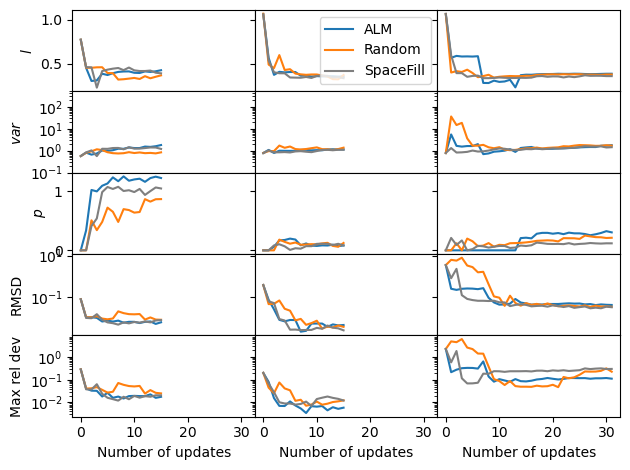

In [28]:
#And another figure with three columns of Rg, U, and Cv
#But now plotting parameters and distance from ground truth
fig, ax = plt.subplots(3+2, 3, sharex=True, sharey='row')

update_labels = ['ALM', 'Random', 'SpaceFill']
update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

run = 'run1'

for i, obs in enumerate(['Rg', 'U', 'Cv']):
    
    for j, lab in enumerate(update_labels):

        #Load training information
        t_info = np.load('%s/%s_log_%s/%s/active_history.npz'%(base_dir, obs, lab, run))
        
        for k in range(3):
            ax[k, i].plot(t_info['params'][:, k], color=update_colors[j], label=update_labels[j])
        
        #Plot deviations from ground truth
        if obs == 'Rg':
            norm_fac = bondL2
            gt_func = ground_truth_rg2
        elif obs == 'U':
            norm_fac = eps
            gt_func = ground_truth_u
        elif obs == 'Cv':
            norm_fac = (-1)
            gt_func = ground_truth_cv
        
        this_rmsd = np.sqrt(np.average((t_info['pred_mu']/norm_fac - gt_func(log_b_vals))**2, axis=-1))    
        this_max_rel_dev = np.max(abs(t_info['pred_mu']/norm_fac - gt_func(log_b_vals)) / abs(gt_func(log_b_vals)),
                                  axis=-1)
        ax[3, i].plot(this_rmsd, color=update_colors[j], label=update_labels[j])
        ax[3+1, i].plot(this_max_rel_dev, color=update_colors[j], label=update_labels[j])
        
ax[0, 1].legend()

for i in range(3):
    ax[-1, i].set_xlabel(r'Number of updates')

ax[1, 0].set_yscale('log')
ax[1, 0].set_ylim((1e-1, 500.0))
ax[-1, 0].set_yscale('log')
ax[-2, 0].set_yscale('log')

ax[0, 0].set_ylabel(r'$l$')
ax[1, 0].set_ylabel(r'$var$')
ax[2, 0].set_ylabel(r'$p$')
ax[3, 0].set_ylabel(r'RMSD')
ax[4, 0].set_ylabel(r'Max rel dev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

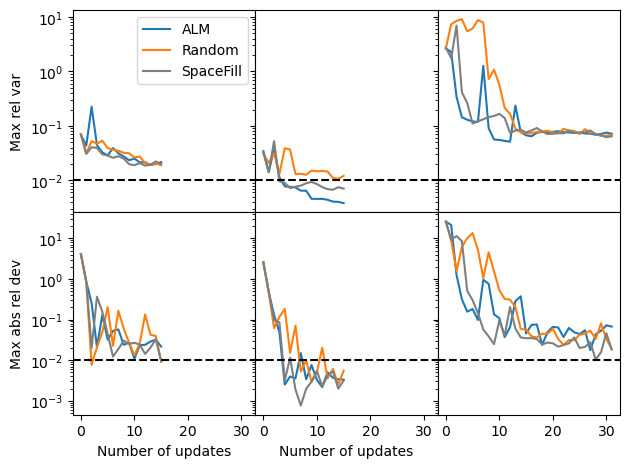

In [31]:
#A figure comparing updates on all observables for stopping metrics
fig, ax = plt.subplots(2, 3, sharex=True, sharey='row')

update_labels = ['ALM', 'Random', 'SpaceFill']
update_colors = ['tab:blue', 'tab:orange', 'tab:gray', 'tab:green']

stop_names = ['MaxRelGlobalVar', 'MaxAbsRelGlobalDeviation']

run = 'run1'

for i, obs in enumerate(['Rg', 'U', 'Cv']):
    
    for j, lab in enumerate(update_labels):

        #Load training information
        t_info = np.load('%s/%s_log_%s/%s/active_history.npz'%(base_dir, obs, lab, run))
        
        for k, sname in enumerate(stop_names):
            ax[k, i].plot(t_info[sname], color=update_colors[j], label=update_labels[j])
    
    for k in range(len(stop_names)):
        ax[k, i].axhline(1e-02, color='k', linestyle='--')
        
ax[0, 0].legend()

for i in range(2):
    ax[-1, i].set_xlabel(r'Number of updates')
    ax[i, 0].set_yscale('log')

ax[0, 0].set_ylabel(r'Max rel var')
ax[1, 0].set_ylabel(r'Max abs rel dev')

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

# Examining raw data

In [16]:
ref_t = (1.0 / (np.array(beta_list) * unit.MOLAR_GAS_CONSTANT_R / unit.kilojoules_per_mole)).value_in_unit(unit.kelvin)

bias_tables = []

for d in data_dirs:
    bias_files = glob.glob(d+'/bias*.npy')
    tot_bias = 0.0
    for bf in bias_files:
        tot_bias += np.load(bf)
    bias_tables.append(tot_bias)


<IPython.core.display.Javascript object>


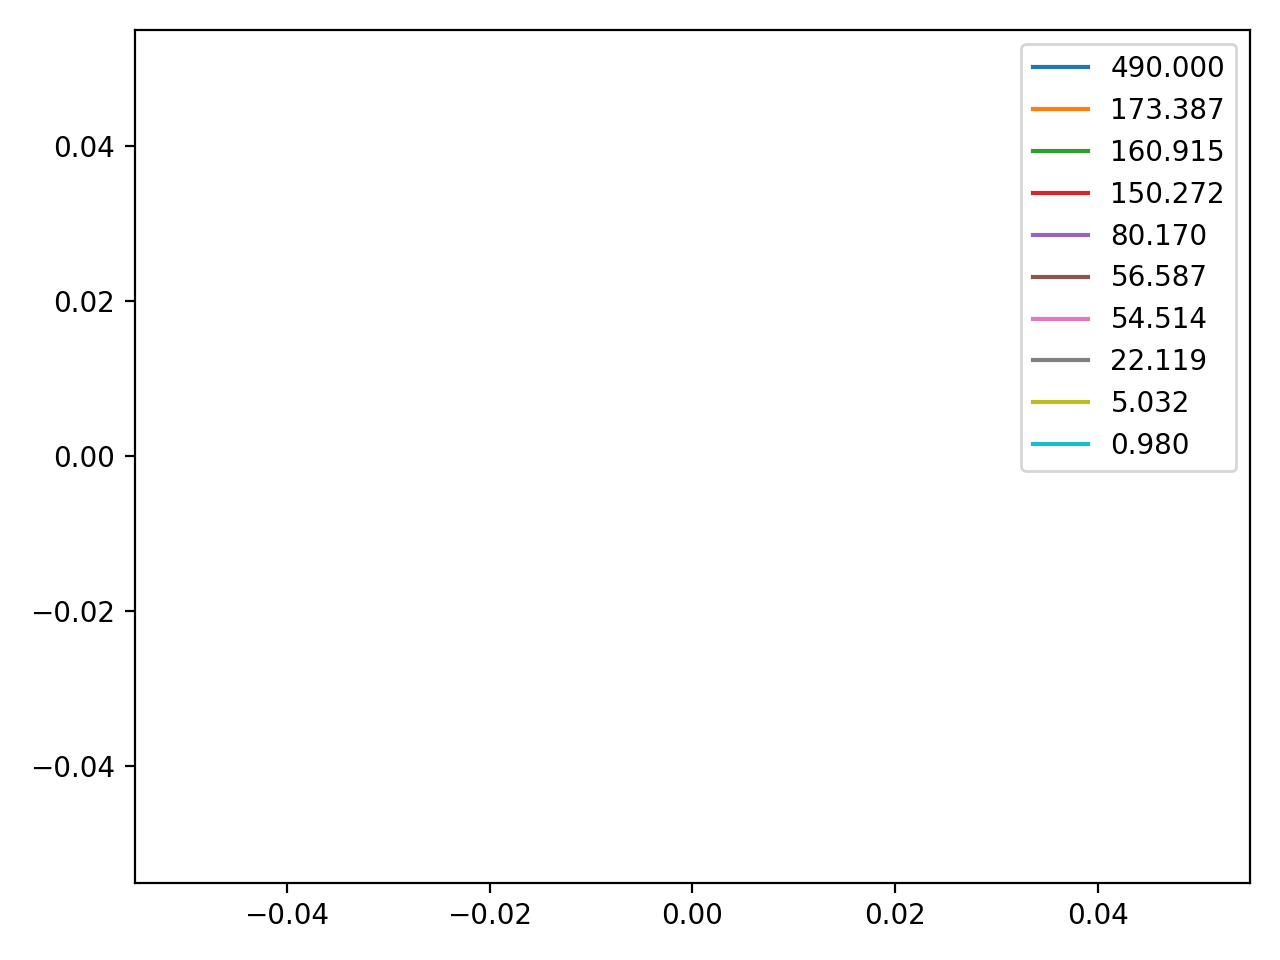

In [17]:
fig, ax = plt.subplots()

for i in range(len(bias_tables)):
    ax.plot(beta_list[i]*bias_tables[i], label='%3.3f'%ref_t[i])

ax.legend()
fig.tight_layout()
plt.show()

In [18]:
cv_vals = []
bias_vals = []
w_vals = []
log_w_vals = []

for d in data_list:
    this_info = d.load_CV_info()
    cv_vals.append(this_info[0])
    bias_vals.append(this_info[1])
    w_vals.append(np.exp(active_utils.get_logweights(this_info[1])))
    log_w_vals.append(active_utils.get_logweights(this_info[1]))


<IPython.core.display.Javascript object>


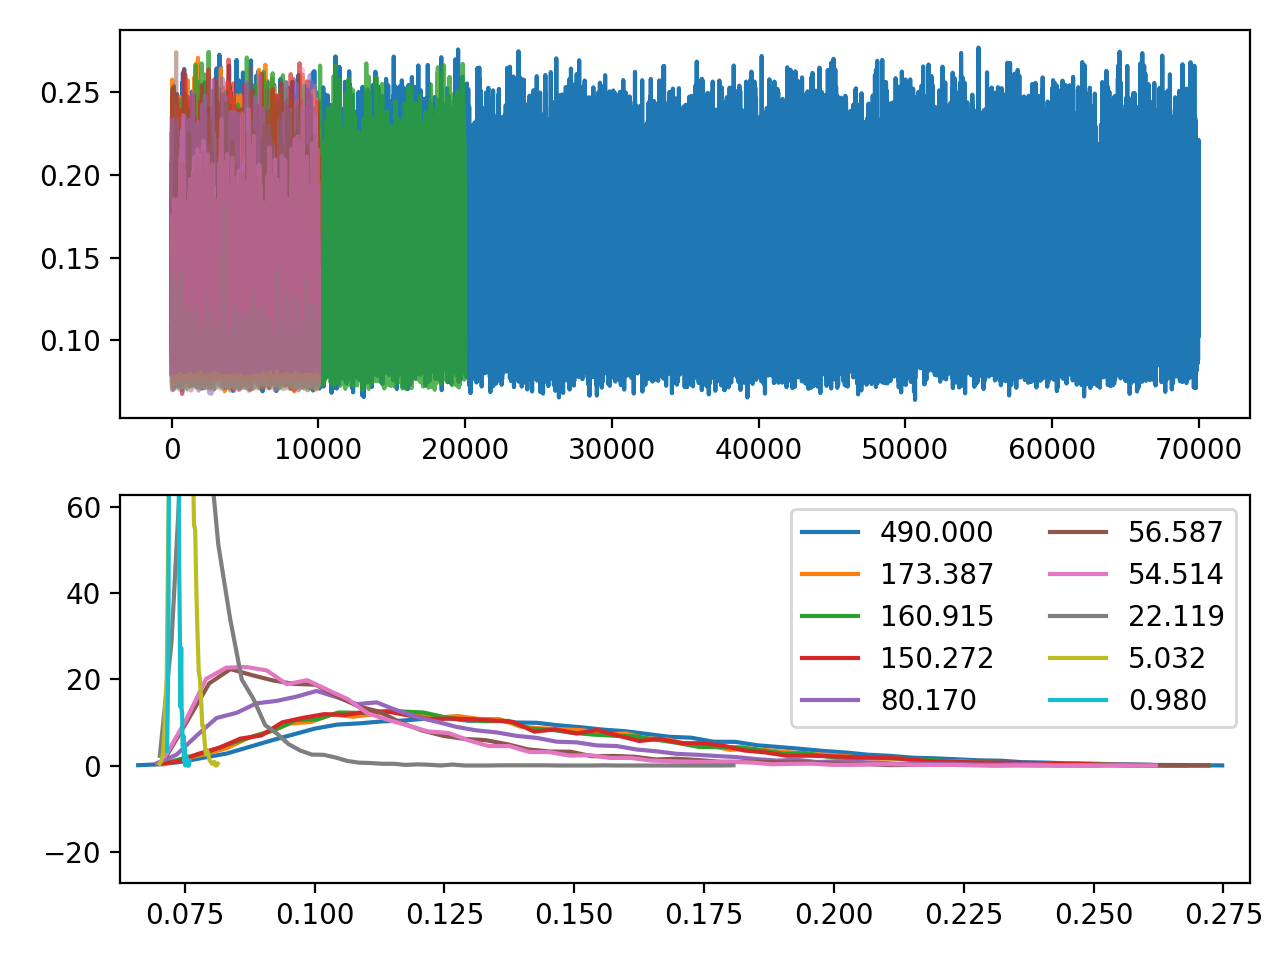

In [20]:
%matplotlib notebook

fig, ax = plt.subplots(2)

for i, vals in enumerate(cv_vals):
    ax[0].plot(vals, label='%3.3f'%ref_t[i], alpha=(len(cv_vals) - i)/len(cv_vals))
    this_hist, this_bins = np.histogram(vals, bins=50, density=True, weights=w_vals[i])
    this_cents = 0.5*(this_bins[:-1] + this_bins[1:])
    ax[1].plot(this_cents, this_hist, label='%3.3f'%ref_t[i])

ax[1].legend(ncol=2)
fig.tight_layout()
plt.show()

In [21]:
from pymbar import timeseries

In [22]:
for i in range(len(data_list)):
    this_g = timeseries.statisticalInefficiency(cv_vals[i])
    print(this_g)


1.0343349541197717
1.0
1.0077243351559182
1.0
1.0196425411492305
1.013175532801743
1.0725546985281125
1.079138058399696
1.356864081185299
8.460215900758422


In [23]:
pot_vals = []

for d in data_list:
    this_info = d.load_U_info()
    #this_info = np.loadtxt(d.sim_info_files[0])[-10000:, 2]
    pot_vals.append(this_info)


<IPython.core.display.Javascript object>


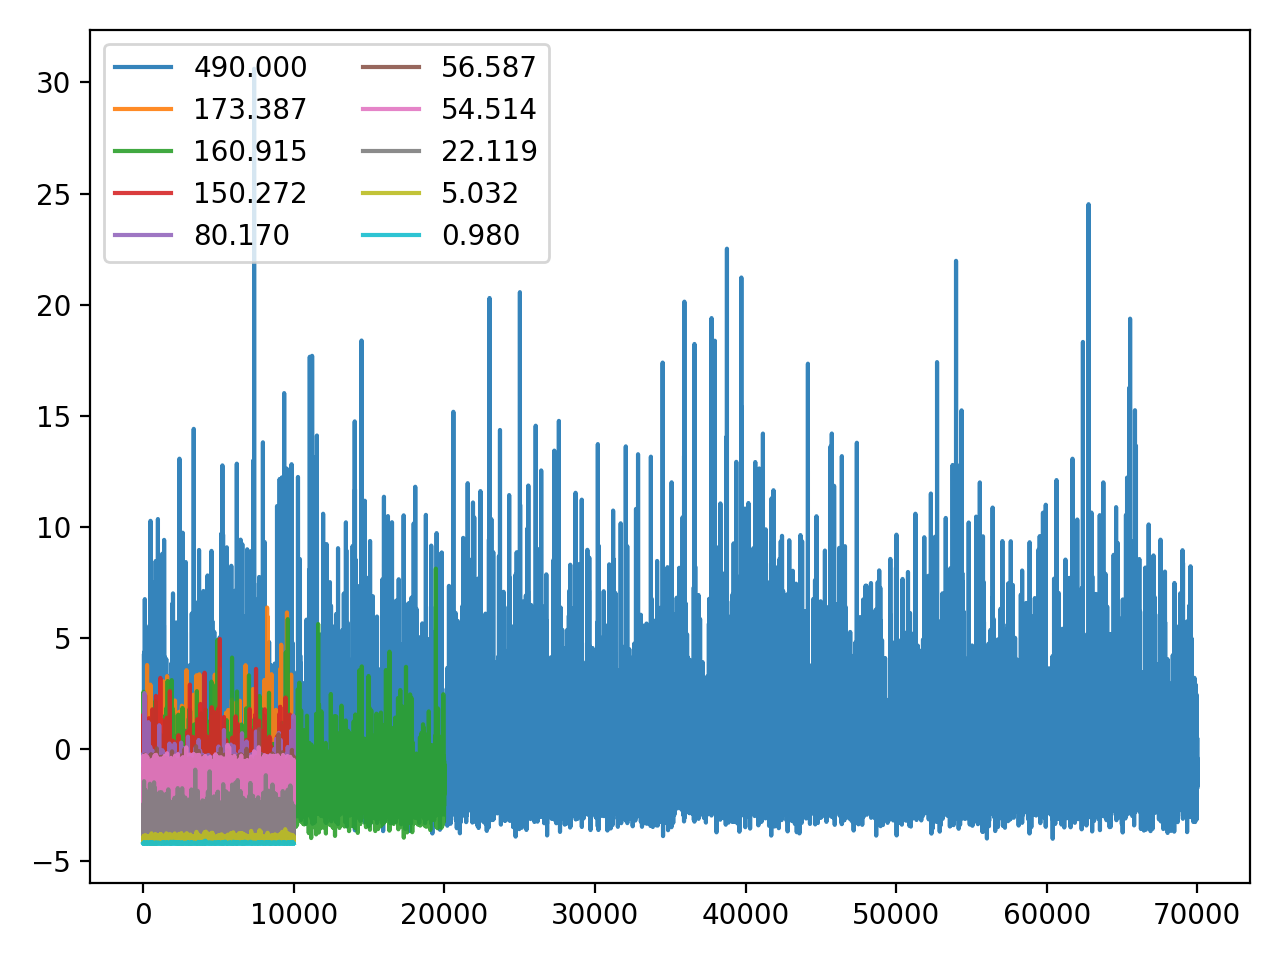

In [24]:
fig, ax = plt.subplots()

for i, pot in enumerate(pot_vals):
    ax.plot(pot-(bias_vals[i]*unit.MOLAR_GAS_CONSTANT_R*ref_t[i]*unit.kelvin).value_in_unit(unit.kilojoules_per_mole),
            label='%3.3f'%ref_t[i], alpha=(len(pot_vals) - 1)/len(pot_vals))

ax.legend(ncol=2)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


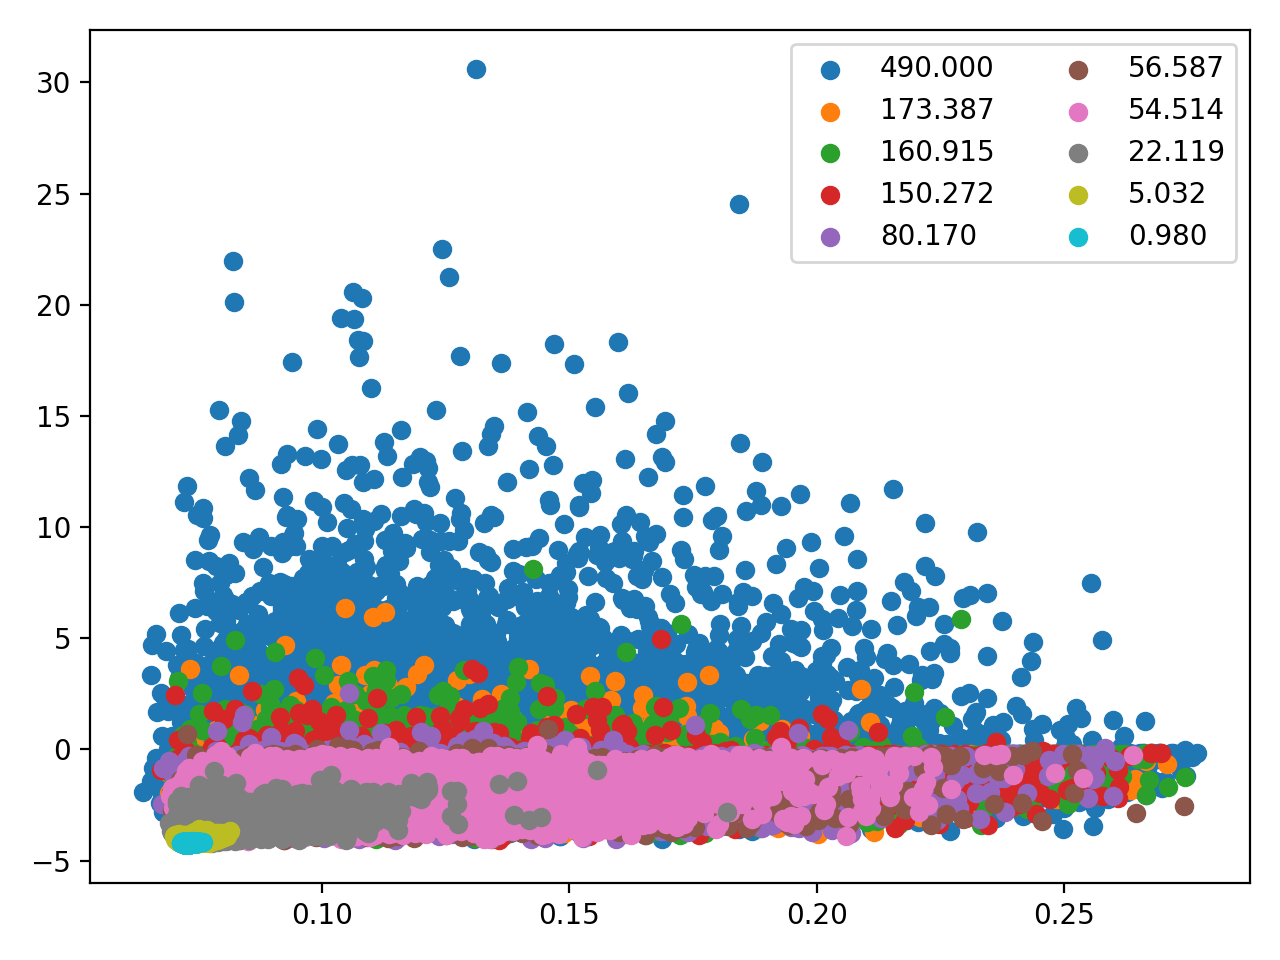

In [25]:
fig, ax = plt.subplots()

for i in range(len(cv_vals)):
    ax.scatter(cv_vals[i], pot_vals[i], label='%3.3f'%ref_t[i])

ax.legend(ncol=2)
fig.tight_layout()
plt.show()

In [26]:
for i in range(len(data_list)):
    this_g = timeseries.statisticalInefficiency(pot_vals[i])
    print(this_g)


1.0208037347068357
1.0
1.0016097270106883
1.0339853302129915
1.0731144687608196
1.0086634927297342
1.0571117132042605
1.0412389406755356
1.3821147844231303
14.362198312420608


In [27]:
for i in range(len(data_list)):
    this_g = timeseries.statisticalInefficiency(cv_vals[i], pot_vals[i])
    print(this_g)


1.1288741024751046
1.0
1.0034310846931562
1.0
1.0395737811181873
1.0
1.1041223842716616
1.0694975287950579
1.76679703878271
20.559288780043303


In [28]:
for i in range(len(data_list)):
    this_g = timeseries.statisticalInefficiency(cv_vals[i]*pot_vals[i])
    print(this_g)
    

1.0110440993557903
1.0
1.0
1.0297539353751677
1.006955328960011
1.0201395682170054
1.0573227494110362
1.0196016888760548
1.0434768680481883
6.728631123928584


In [29]:
for i in range(len(data_list)):
    this_g = timeseries.statisticalInefficiency((cv_vals[i] - np.average(cv_vals[i]))
                                                 *(pot_vals[i] - np.average(pot_vals[i])))
    print(this_g)


1.0005503273568357
1.0862370028545347
1.0170608542990274
1.0034029335067793
1.0
1.0
1.0898174163025045
1.0
1.1292429393267498
11.961638457325536
